<a href="https://colab.research.google.com/github/bogomolga/VersionControl_Seminar3/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%222_%D0%B2%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_%D0%BF%D0%BE_AutoML_(%D0%BC%D0%B0%D1%80%D1%82_2023)%7C_KerasTuner_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Датасет с табличными данными

In [ ]:
#@title Загрузка датасета и подготовка выборок
# Подключение библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import gdown
import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")  # 'ignore'   Никогда не печатать соответствующие предупреждения
sns.set_style('darkgrid')

from tensorflow.keras.metrics import Precision, Recall

metrics = [
    'accuracy',
    Recall(name="recall"),
    Precision(name="precision")
]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Worker:
  def __init__(self):
    self.dsname = None

  def load_dataset(self):
    self.dsname=gdown.download('https://storage.yandexcloud.net/aiueducation/marketing/datasets/medicine.csv', None, quiet=True)
    print(f'Датасет загружен!\n')

  def show_dataset(self):
    self.dftrain = pd.read_csv(self.dsname, index_col=0)
    # Удаляем не нужный столбец 
    del self.dftrain['ID_y']
    display(self.dftrain.head())


  def dataset_info(self):
    for col in self.dftrain.columns:        
      print(f'----- Параметр {col} -----')
      data = self.dftrain[col].value_counts()
      plt.figure(figsize=(14,6))
      plt.xticks(rotation='vertical')
      xlabels = [f'{x} ({y})' for x,y in zip(list(data.index), data)]
      plt.bar(xlabels[::-1], data[::-1])
      plt.show()

  # Конвертация данных в числовое представление
  def convertToNumeric(self, columns):
    self.dfnumeric = self.dftrain.copy()
    le = LabelEncoder() 
    for feat in columns:
        self.dfnumeric[feat] = le.fit_transform(self.dfnumeric[feat].astype(str))
    self.dfnumeric.fillna(0, inplace=True)
    display(self.dfnumeric.head())

  def matrix_corr(self):
    ###   КОРРЕЛЯЦИЯ - КРИТЕРИЙ СПИРМЕНА
    # Метод, подсчитывающий попарную корреляцию для элементов.
    corr_matrix = self.dfnumeric.corr('spearman') 

    # Можно указать в параметрах способ подсчета.
    plt.figure(figsize=(25, 25))
    sns.heatmap(corr_matrix, cmap= 'coolwarm', vmin=-1, center=0, linewidths=2,
                linecolor='black', annot = True, fmt='.1g') 

    plt.show()

  def create_sets(self):
    # Формирование выборки x
    colX = list(self.dfnumeric.columns[:-5])
    x_data = self.dfnumeric[colX].values
    colY = list(self.dfnumeric.columns[-5:])
    y_data = self.dfnumeric.iloc[:, -5:].values
    # Разбиение общей выборки на обучающую и проверочную 
    self.x_train, self.x_val, self.y_train, self.y_val  = train_test_split(x_data, y_data,
                                                    test_size=0.1, 
                                                    shuffle=True,
                                                    random_state = 14)
    print('Выборки созданы! Размеры:')
    print(f'x_train: {self.x_train.shape}')
    print(f'y_train: {self.y_train.shape}')
    print(f'x_val: {self.x_val.shape}')
    print(f'y_val: {self.y_val.shape}')


  def show_learning_information(self, history):
    print('График обучения:')
    # Создание полотна для рисунка
    f, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    ax[0].plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
    ax[0].plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей 
    ax[0].set_title('Метрика: accuracy')

    ax[1].plot(history.history['precision'], 
            label='Доля верных ответов на обучающем наборе')
    ax[1].plot(history.history['val_precision'], 
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей 
    ax[1].set_title('Метрика: precision')

    ax[2].plot(history.history['recall'], 
            label='Доля верных ответов на обучающем наборе')
    ax[2].plot(history.history['val_recall'], 
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей 
    ax[2].set_title('Метрика: recall')
    # Фиксация графиков и рисование всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')
    
    print(f'Максимальная метрика precision  на обучающей выборке: {round(np.array(history.history["precision"]).max(), 3)}')
    print(f'Максимальная метрика precision  на проверочной выборке: {round(np.array(history.history["val_precision"]).max(), 3)}')
    
    print(f'Максимальная метрика recall на обучающей выборке: {round(np.array(history.history["recall"]).max(), 3)}')
    print(f'Максимальная метрика recall на проверочной выборке: {round(np.array(history.history["val_recall"]).max(), 3)}')



  def train_model(self, funcModel, count):
    # Обучение модели сверточной нейронной сети подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    history_recall = []
    history_val_recall = []
    history_precision = []
    history_val_precision  = []
    for i in range(cnt):
      model = funcModel()      
      store_learning = model.fit(self.x_train,
                                self.y_train,
                                validation_data=(self.x_val, self.y_val),
                                shuffle=True,
                                batch_size=25,
                                epochs=50, 
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])

      history_recall.append(store_learning.history['recall'])
      history_val_recall.append(store_learning.history['val_recall'])

      history_precision.append(store_learning.history['precision'])
      history_val_precision.append(store_learning.history['val_precision'])
      print(f'{bcolors.BOLD}{bcolors.OKBLUE}Обучение №{i+1} завершено. Результаты{bcolors.ENDC}')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      print()
      print(f'Максимальная метрика precision на обучающей выборке: {round(np.array(store_learning.history["precision"]).max(), 3)}')
      print(f'Максимальная метрика precision на проверочной выборке: {round(np.array(store_learning.history["val_precision"]).max(), 3)}')
      print()
      print(f'Максимальная метрика recall на обучающей выборке: {round(np.array(store_learning.history["recall"]).max(), 3)}')
      print(f'Максимальная метрика recall на проверочной выборке: {round(np.array(store_learning.history["val_recall"]).max(), 3)}')
      
      print('\n'*3)
    print(f'{bcolors.BOLD}###############################################################################{bcolors.ENDC}')
    print(f'{bcolors.HEADER} Финальные результаты{bcolors.ENDC}')
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')
    print()
    print(f'Средняя метрика precision на обучающей выборке: {round(np.array(history_precision).max(axis=1).mean(), 3)}')
    print(f'Максимальная метрика precision на обучающей выборке: {round(np.array(history_precision).max(), 3)}')
    print(f'Средняя метрика precision на проверочной выборке: {round(np.array(history_val_precision).max(axis=1).mean(), 3)}')
    print(f'Максимальная метрика precision на проверочной выборке: {round(np.array(history_val_precision).max(), 3)}')
    print()
    print(f'Средняя метрика recall на обучающей выборке: {round(np.array(history_recall).max(axis=1).mean(), 3)}')
    print(f'Максимальная метрика recall на обучающей выборке: {round(np.array(history_recall).max(), 3)}')
    print(f'Средняя метрика recall на проверочной выборке: {round(np.array(history_val_recall).max(axis=1).mean(), 3)}')
    print(f'Максимальная метрика recall на проверочной выборке: {round(np.array(history_val_recall).max(), 3)}')

  def create_net_from_bot(self, bot):    
    print(f'{bcolors.OKBLUE}{bcolors.UNDERLINE}Выбранные параметры{bcolors.ENDC}')
    columns_from_bot = np.array(bot[-self.x_train.shape[1]:])
    columns = self.dftrain.columns
    for i in range(len(columns_from_bot)):
      if columns_from_bot[i]:
        print(f'   {bcolors.OKGREEN}{bcolors.BOLD}{columns[i]}{bcolors.ENDC}')
      else:
        print(f'   {bcolors.FAIL}{bcolors.BOLD}{columns[i]}{bcolors.ENDC}')
    
    #Создаём сеть (net - список параметров)  
    print(f'{bcolors.OKBLUE}{bcolors.UNDERLINE}\nСтруктура модели{bcolors.ENDC}')  
    columns = np.array(bot[-self.x_train.shape[1]:])  
    model = Sequential()             # Создаем моель Sequential
    print(f'  model = Sequential()')

    '''
    Присвоение значений параметрам слоев из значений полученного бота
  
    Входной блок
    '''
    makeFirstNormalization = bot[0]  # Делаем ли нормализацию в начале
    firstDenseSize = 2 ** bot[1]     # Размер Dense-слоя  
    activation0 = bot[2]             # Функция активации входного слоя
    dropout0 = bot[3]                # Делаем ли дропаут
    dropout0_size= bot[4]            # Размер дропаута

    '''
    Первый скрытый
    '''
    makeSecond  = bot[5]             # Делаем ли второй свёрточный слой
    secondDenseSize = 2 ** bot[6]     # Размер второго слоя
    activation1 = bot[7]             # Функция активации входного слоя
    dropout1 = bot[8]                # Делаем ли дропаут
    dropout1_size= bot[9]            # Размер дропаута

    '''
    Второй скрытый
    '''
    makeThird  = bot[10]             # Делаем ли второй свёрточный слой
    thirdDenseSize = 2 ** bot[11]    # Размер второго слоя
    activation2 = bot[12]             # Функция активации входного слоя
    dropout2 = bot[13]                # Делаем ли дропаут
    dropout2_size= bot[14]            # Размер дропаута

    '''
    Выходной dense блок
    '''
    denseSize1 = 2 ** bot[15]        # Размер предпоследнего полносвязного слоя 
    activationdense1 = bot[16]       # Функция активации предпоследнего полносвязного слоя 
    makeSecondNormalization = bot[17]  # Делаем ли нормализацию в начале
    activationdense2 = bot[18]       # Функция активации дпоследнего полносвязного слоя 

    '''
    Список активационных функций
    '''
    activation_list = ['linear','relu', 'elu', 'selu' ,'tanh', 'sigmoid'] 


    '''
    Условия для формирования блоков
    _______________________________

    Входной Conv блок
    '''
    # Если делаем нормализацию в начале
    if (makeFirstNormalization):      
        # Добавляем слой BatchNormalization
        model.add(BatchNormalization(input_dim=np.array((columns==1)).sum()))
        print(f'  model.add(BatchNormalization(input_dim={np.array((columns==1)).sum()}))')

        # Добавляем слой 
        model.add(Dense(firstDenseSize, activation=activation_list[activation0])) 
        print(f'  model.add(Dense({firstDenseSize}, activation="{activation_list[activation0]}"))')

    else:
        # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
        model.add(Dense(firstDenseSize, activation=activation_list[activation0], input_dim=np.array((columns==1)).sum()))
        print(f'  model.add(Dense({firstDenseSize}, activation="{activation_list[activation0]}", input_dim={np.array((columns==1)).sum()}))')
        # Если делаем maxpooling
    if dropout0:               
        model.add(Dropout(dropout0_size))
        print(f'  model.add(Dropout({dropout0_size}))')

    '''
    Первый скрытый блок
    '''
    # Если делаем второй свёрточный слой
    if (makeSecond):              
        # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
        model.add(Dense(secondDenseSize, activation=activation_list[activation1])) 
        print(f'  model.add(Dense({secondDenseSize}, activation="{activation_list[activation1]}"))')
        
        # Если делаем MaxPooling      
        if dropout1:
          model.add(Dropout(dropout1_size))
          print(f'  model.add(Dropout({dropout1_size}))')

    '''
    Второй скрытый блок
    '''
    # Если делаем второй свёрточный слой
    if (makeThird):              
        # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
        model.add(Dense(thirdDenseSize, activation=activation_list[activation2])) 
        print(f'  model.add(Dense({thirdDenseSize}, activation="{activation_list[activation2]}"))')
        
        # Если делаем MaxPooling      
        if dropout2:
          model.add(Dropout(dropout2_size))
          print(f'  model.add(Dropout({dropout2_size}))')

    '''
    Выходной dense блок
    '''
    # Если делаем финальную нормализацию         
    if (makeSecondNormalization):     
        model.add(BatchNormalization()) # Добавляем слой BatchNormalization
        print(f'  model.add(BatchNormalization())')
    # Добавляем слой Dense с denseSize нейронами  
    model.add(Dense(denseSize1, activation=activation_list[activationdense1]))
    print(f'  model.add(Dense({denseSize1}, activation="{activation_list[activationdense1]}"))')
    # Добавляем Dense-слой с softmax-активацией и 10 нейронами
    model.add(Dense(5, activation="sigmoid"))
    print(f'  model.add(Dense(5, activation="sigmoid"))')
    
    model.compile(optimizer=Adam(0.005), loss='categorical_crossentropy', metrics=[metrics])
    print(f'{bcolors.OKBLUE}{bcolors.UNDERLINE}\nОбучение модели{bcolors.ENDC}')  
    store_learning = model.fit(self.x_train[:, np.array(bot[-self.x_train.shape[1]:])==1],
                              self.y_train,
                              validation_data=(self.x_val[:, np.array(bot[-self.x_train.shape[1]:])==1], self.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=0)
    self.show_learning_information(store_learning)

worker=Worker()

In [ ]:
# Загрузка датасета
worker.load_dataset()

Датасет загружен!



# Статистика по датасету:

In [ ]:
# Выводи примеров
worker.show_dataset()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
ID,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,...,22:00:00,06:00:00,0,0,0,0,0,0,0,0
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,...,00:00:00,04:00:00,1,0,0,1,1,0,0,0
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,...,23:00:00,07:00:00,0,0,0,0,0,0,0,0
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,...,23:00:00,07:00:00,0,0,0,1,0,0,0,0
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,...,23:00:00,06:00:00,0,0,0,1,0,1,1,0


----- Параметр Пол -----


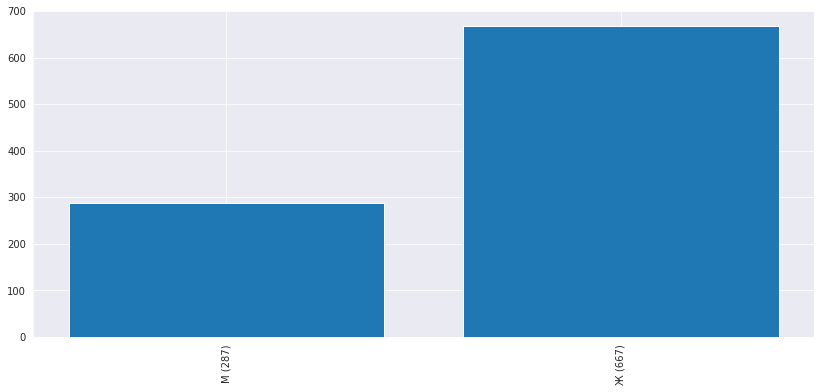

----- Параметр Семья -----


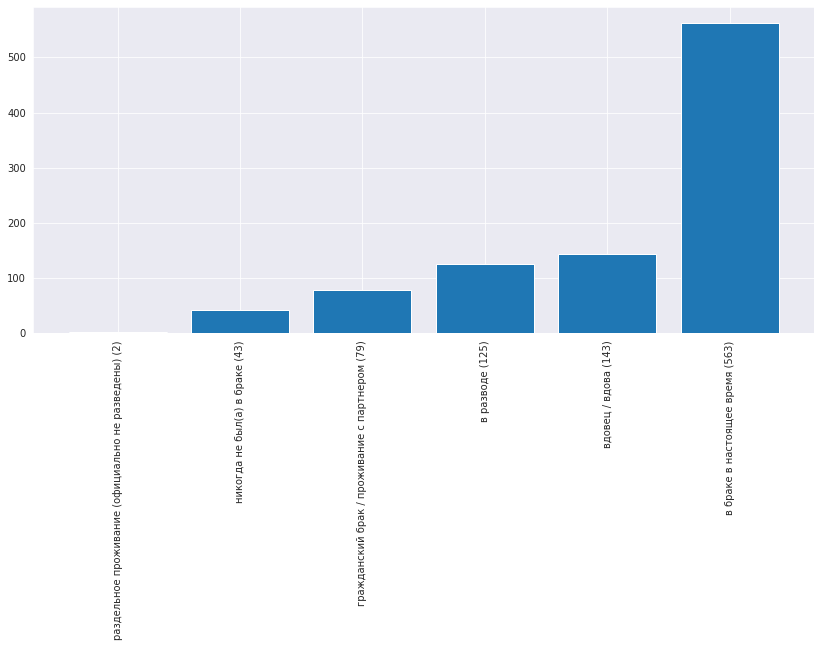

----- Параметр Этнос -----


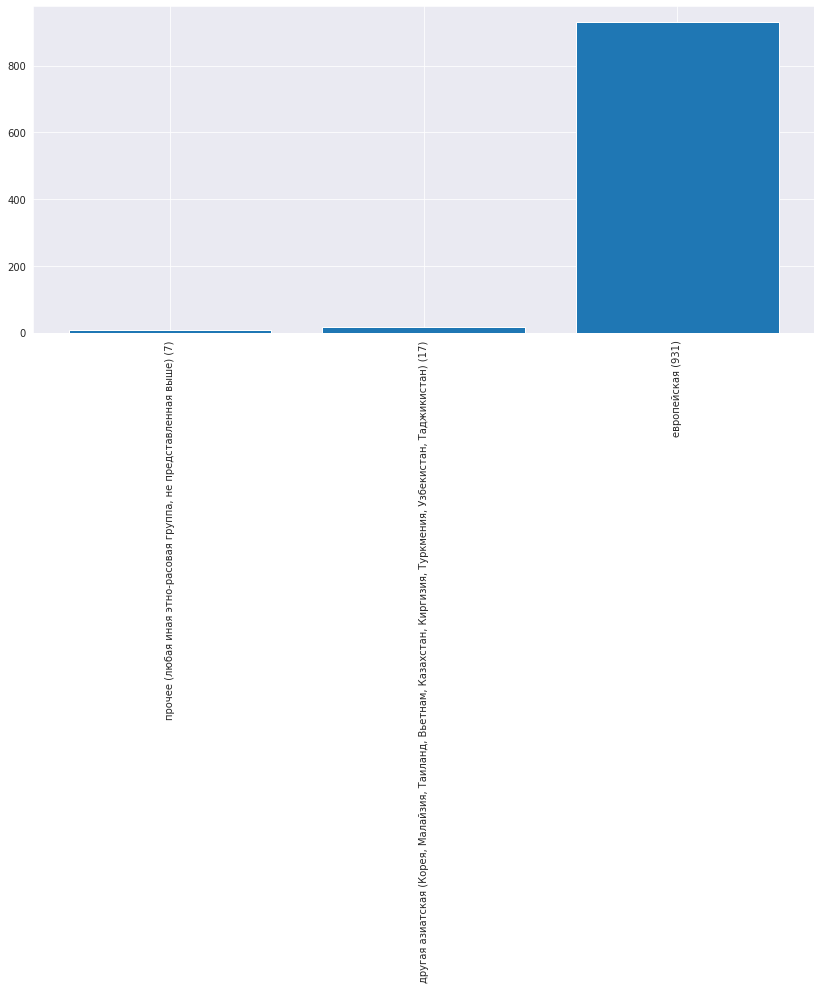

----- Параметр Национальность -----


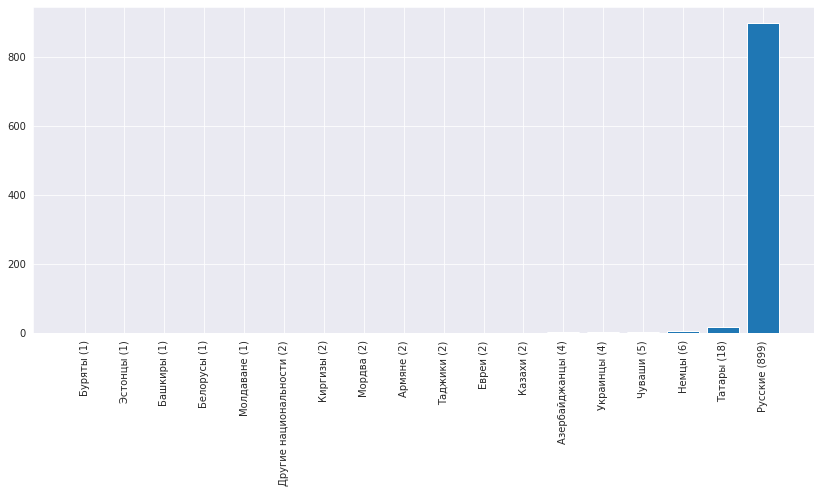

----- Параметр Религия -----


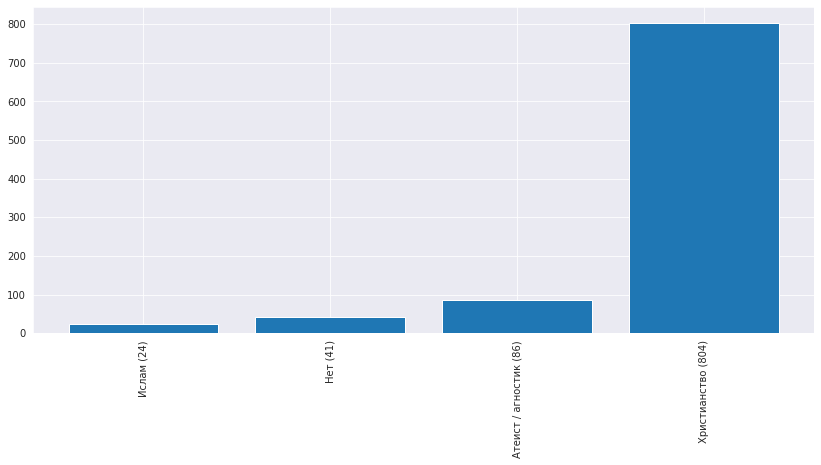

----- Параметр Образование -----


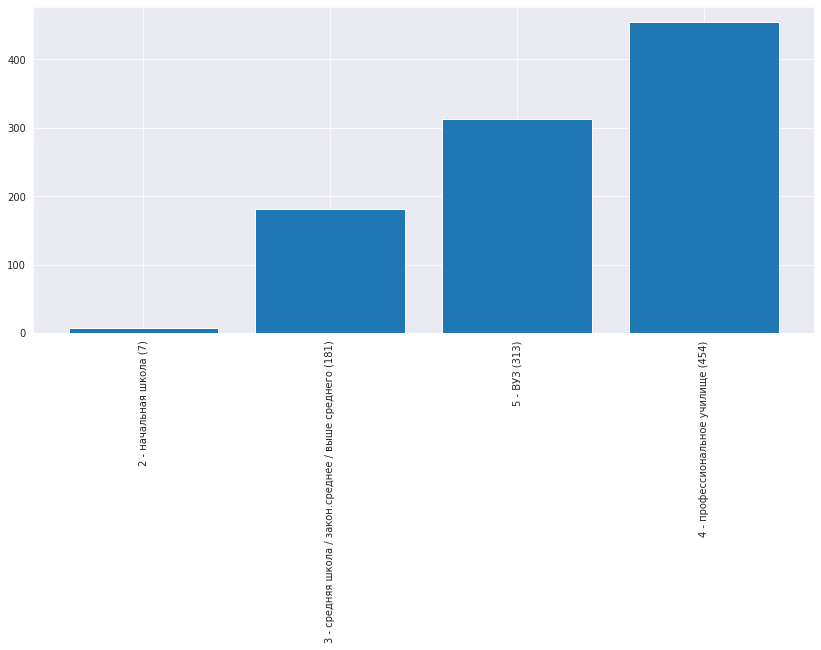

----- Параметр Профессия -----


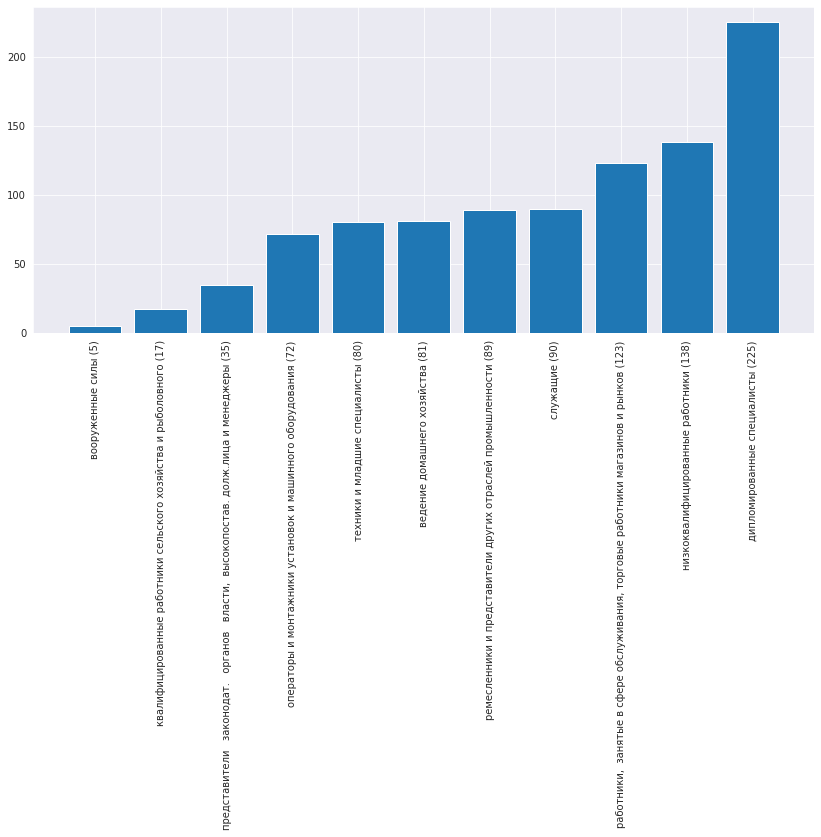

----- Параметр Вы работаете? -----


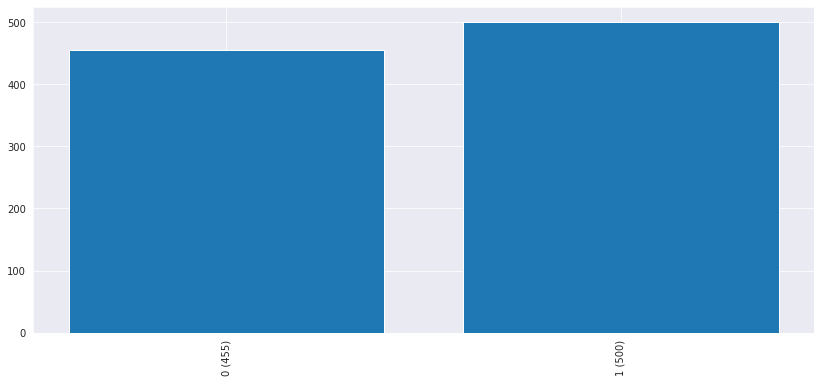

----- Параметр Выход на пенсию -----


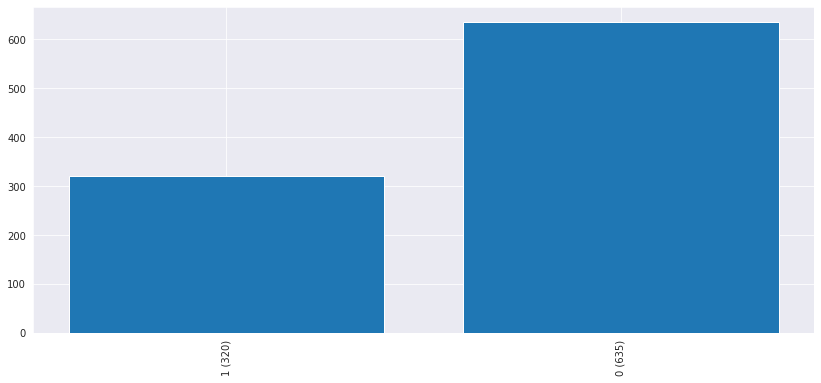

----- Параметр Прекращение работы по болезни -----


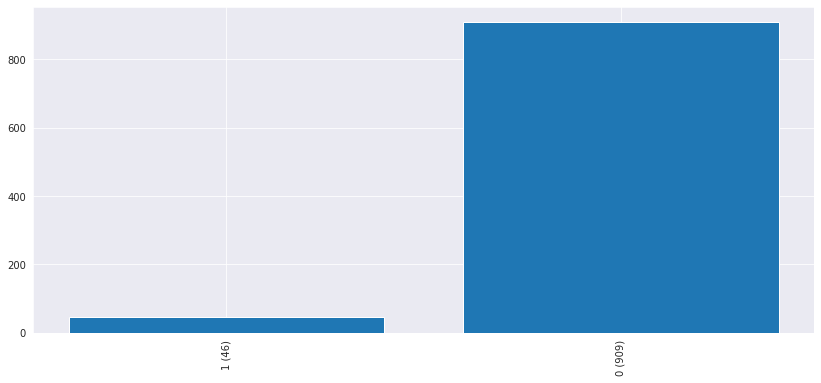

----- Параметр Сахарный диабет -----


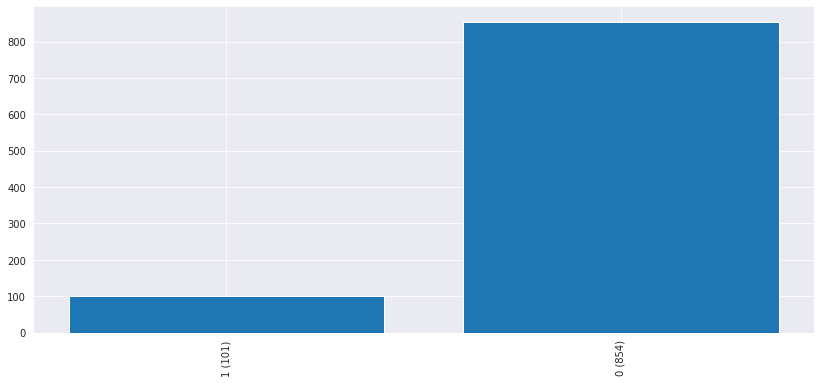

----- Параметр Гепатит -----


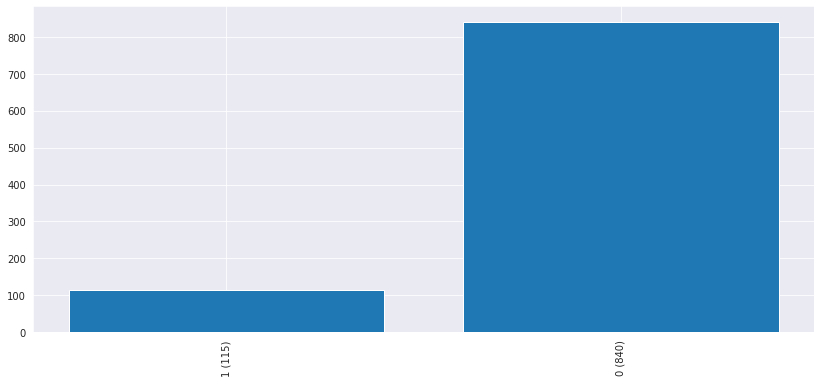

----- Параметр Онкология -----


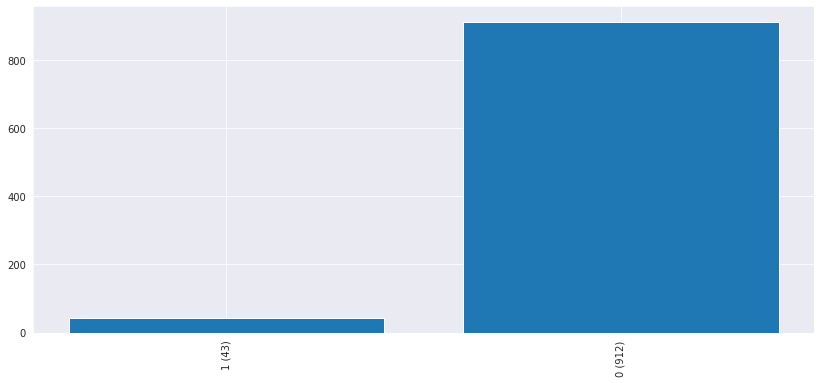

----- Параметр Хроническое заболевание легких -----


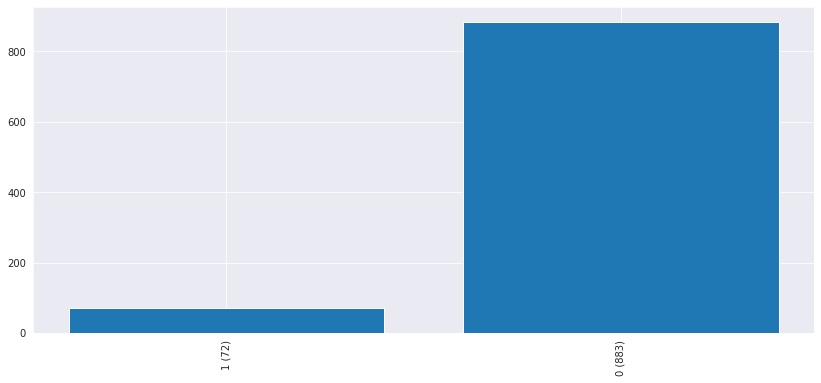

----- Параметр Бронжиальная астма -----


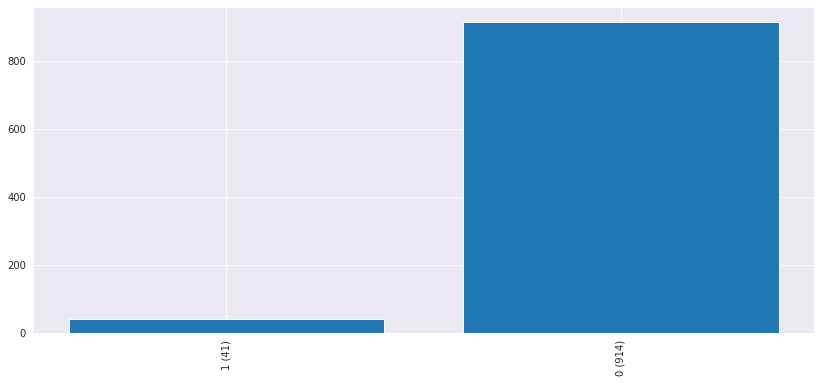

----- Параметр Туберкулез легких  -----


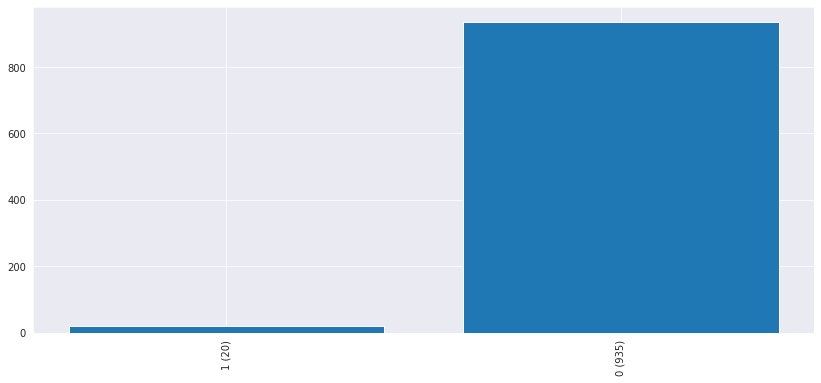

----- Параметр ВИЧ/СПИД -----


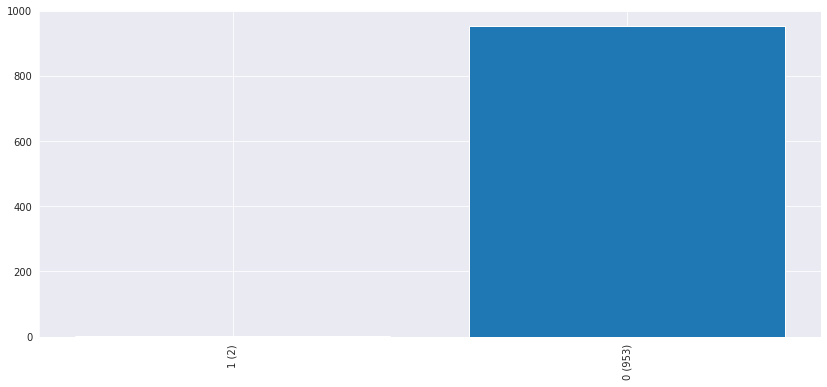

----- Параметр Регулярный прим лекарственных средств -----


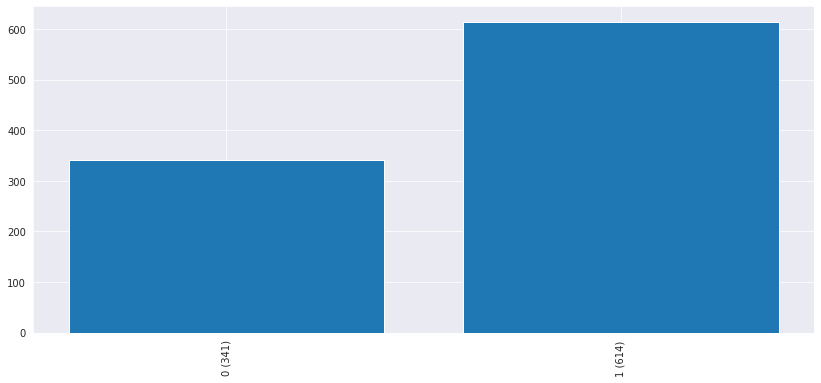

----- Параметр Травмы за год -----


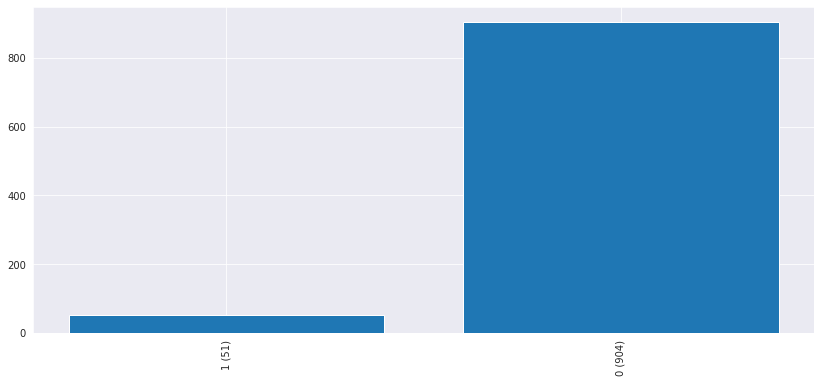

----- Параметр Переломы -----


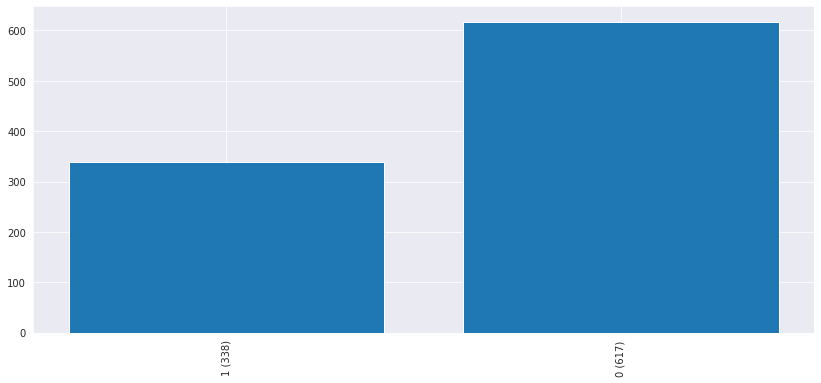

----- Параметр Статус Курения -----


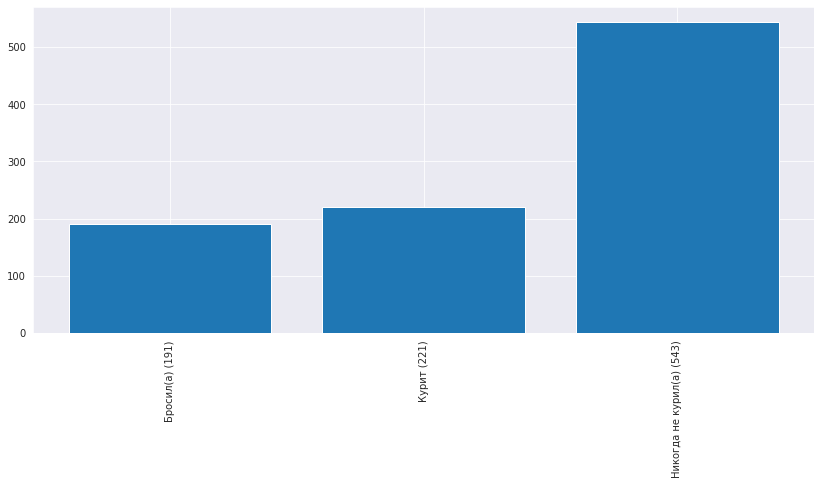

----- Параметр Возраст курения -----


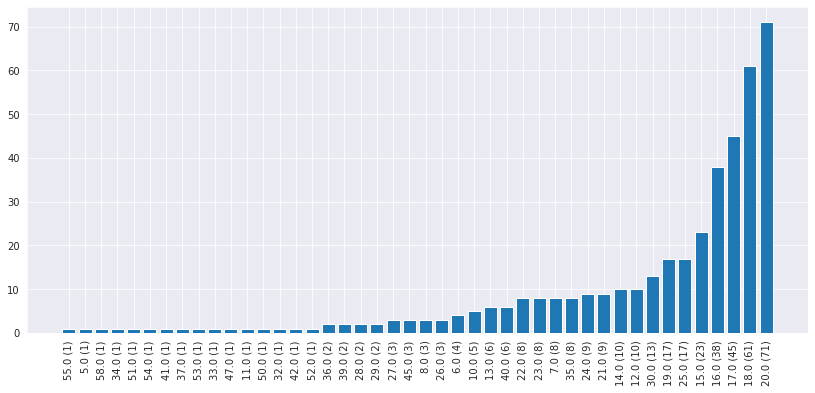

----- Параметр Сигарет в день -----


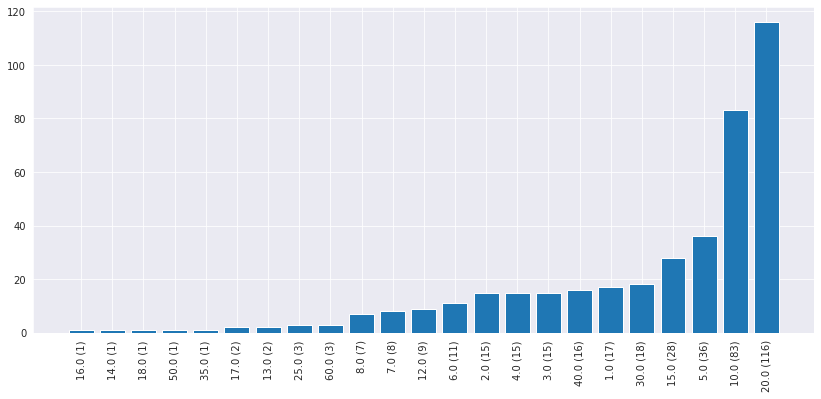

----- Параметр Пассивное курение -----


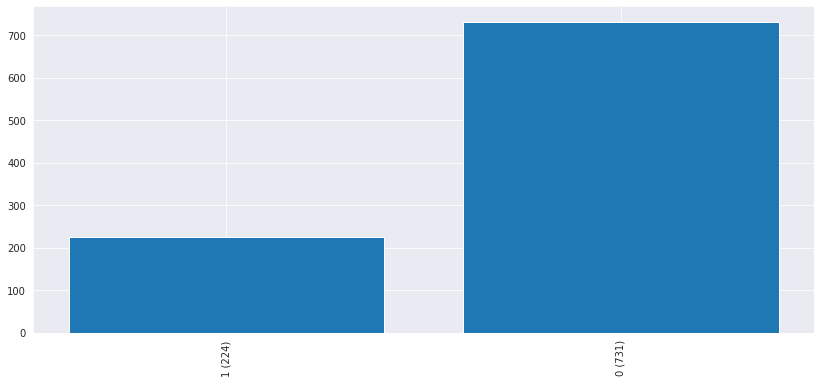

----- Параметр Частота пасс кур -----


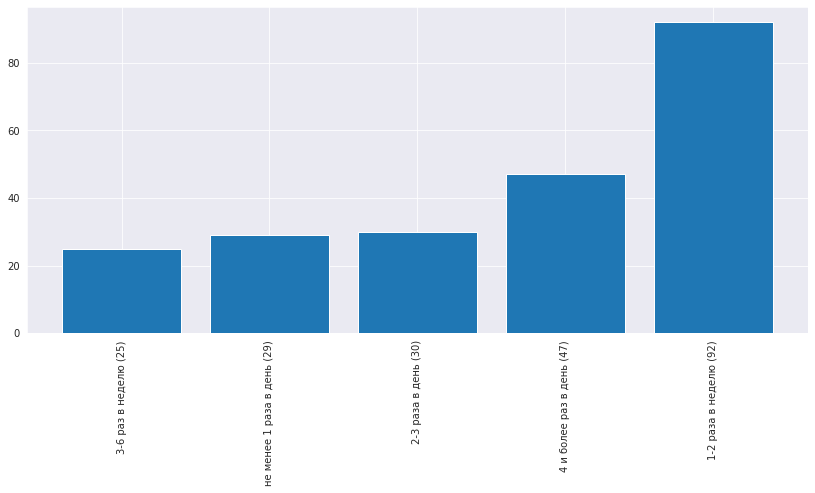

----- Параметр Алкоголь -----


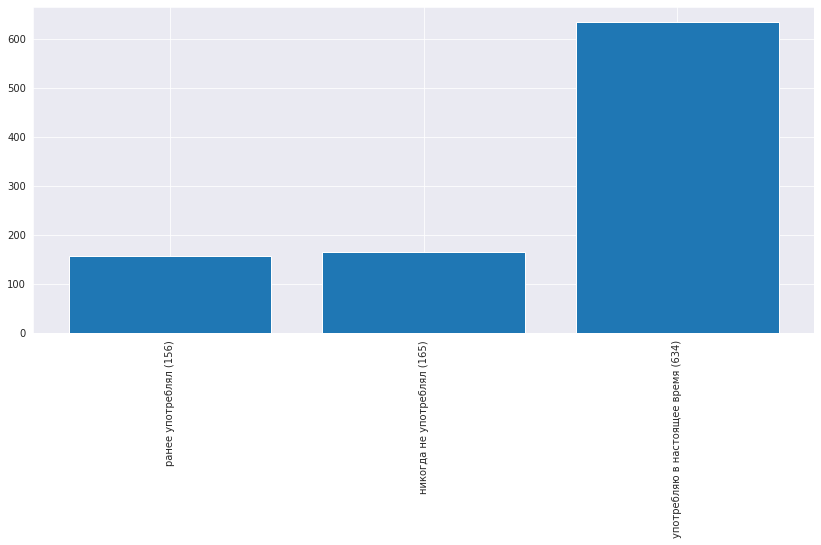

----- Параметр Возраст алког -----


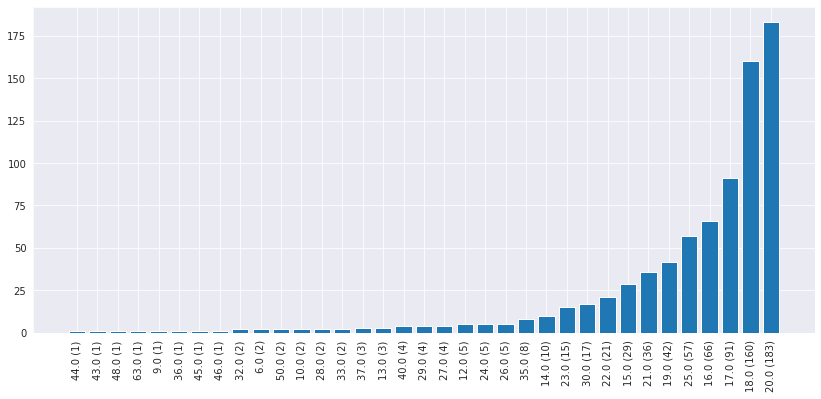

----- Параметр Время засыпания -----


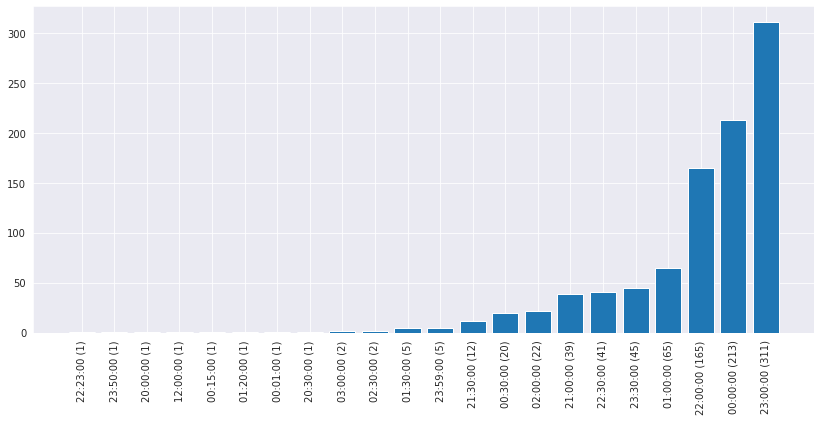

----- Параметр Время пробуждения -----


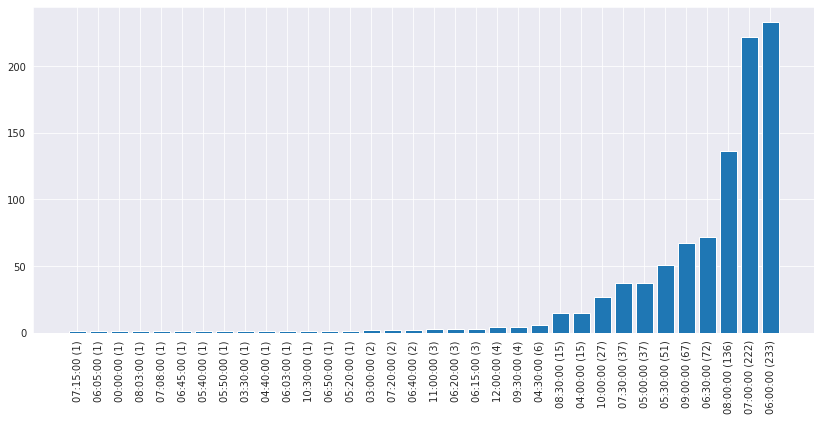

----- Параметр Сон после обеда -----


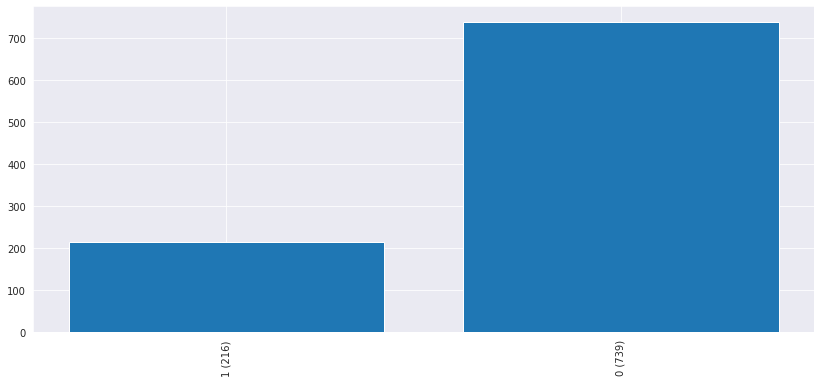

----- Параметр Спорт, клубы -----


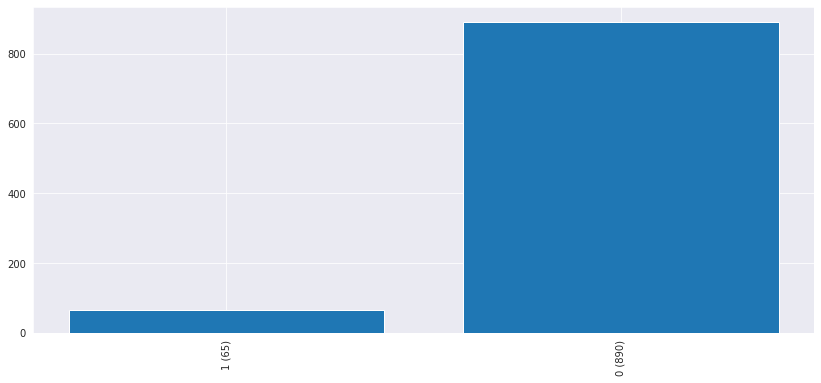

----- Параметр Религия, клубы -----


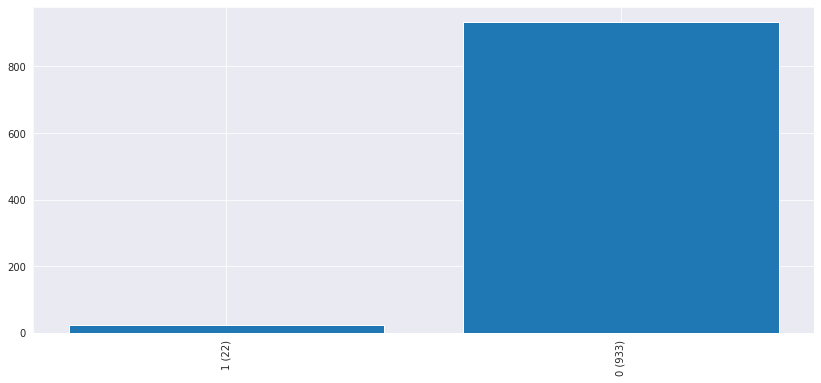

----- Параметр Артериальная гипертензия -----


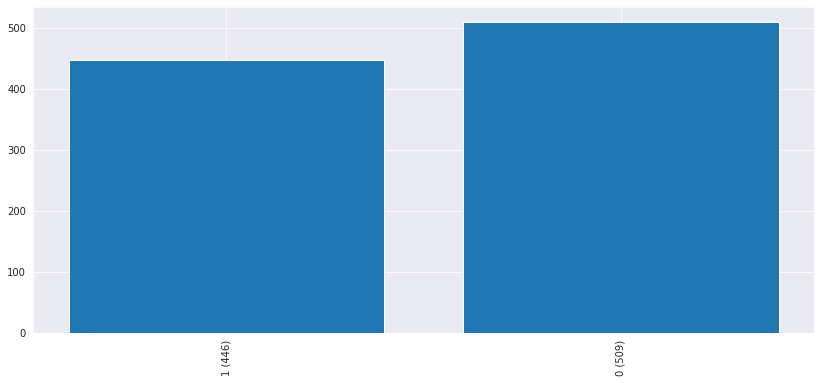

----- Параметр ОНМК -----


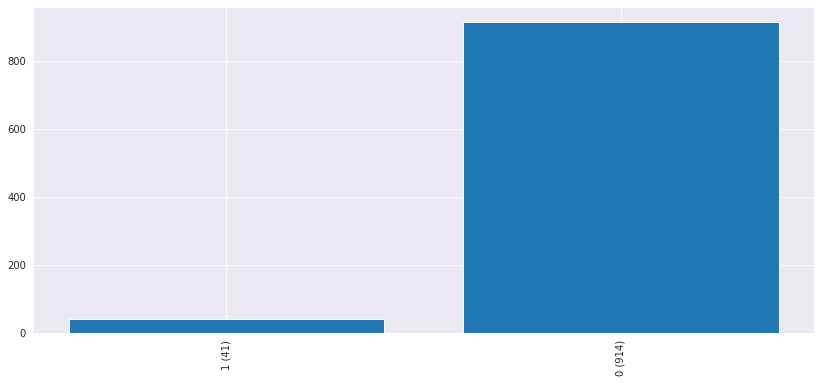

----- Параметр Стенокардия, ИБС, инфаркт миокарда -----


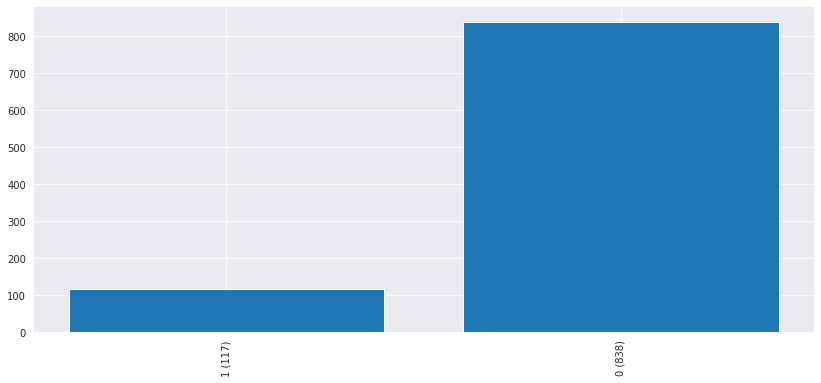

----- Параметр Сердечная недостаточность -----


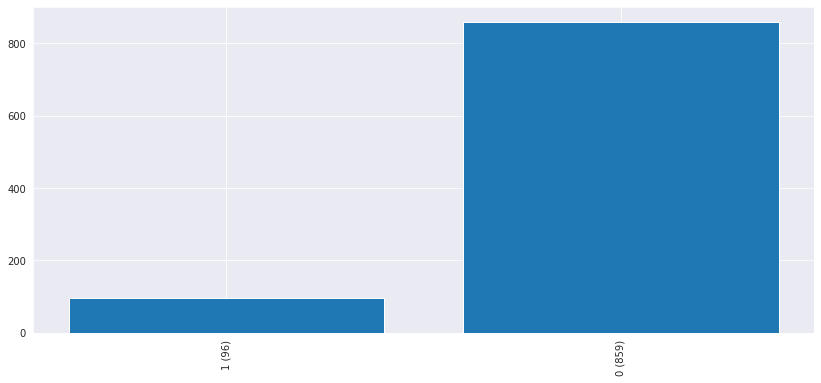

----- Параметр Прочие заболевания сердца -----


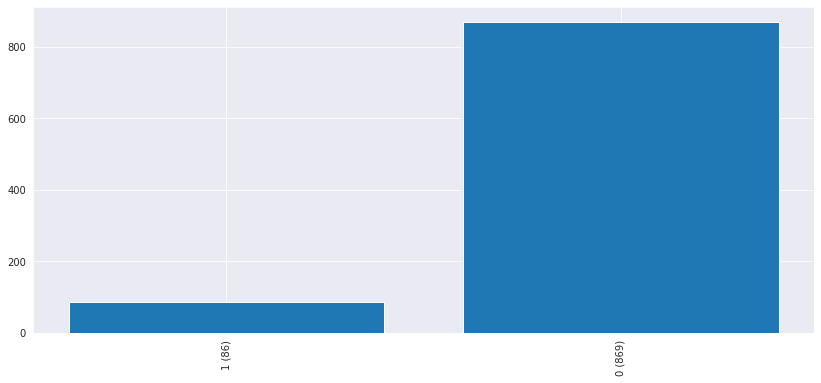

In [ ]:
# Информация о датасете
worker.dataset_info()

In [ ]:
# Оцифровка категориальных признаков
worker.convertToNumeric(["Пол", 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Статус Курения', 'Частота пасс кур', 'Алкоголь', 'Время засыпания', 'Время пробуждения'] )

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
ID,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,2,0,1,12,3,1,4,1,0,0,...,15,11,0,0,0,0,0,0,0,0
54-103-101-01,1,1,1,12,3,3,2,0,0,0,...,0,3,1,0,0,1,1,0,0,0
54-501-026-03,1,0,1,12,3,3,2,0,0,0,...,18,20,0,0,0,0,0,0,0,0
54-501-094-02,2,0,1,12,0,1,4,1,0,0,...,18,20,0,0,0,1,0,0,0,0
54-503-022-01,1,0,1,12,3,1,5,0,0,1,...,18,11,0,0,0,1,0,1,1,0


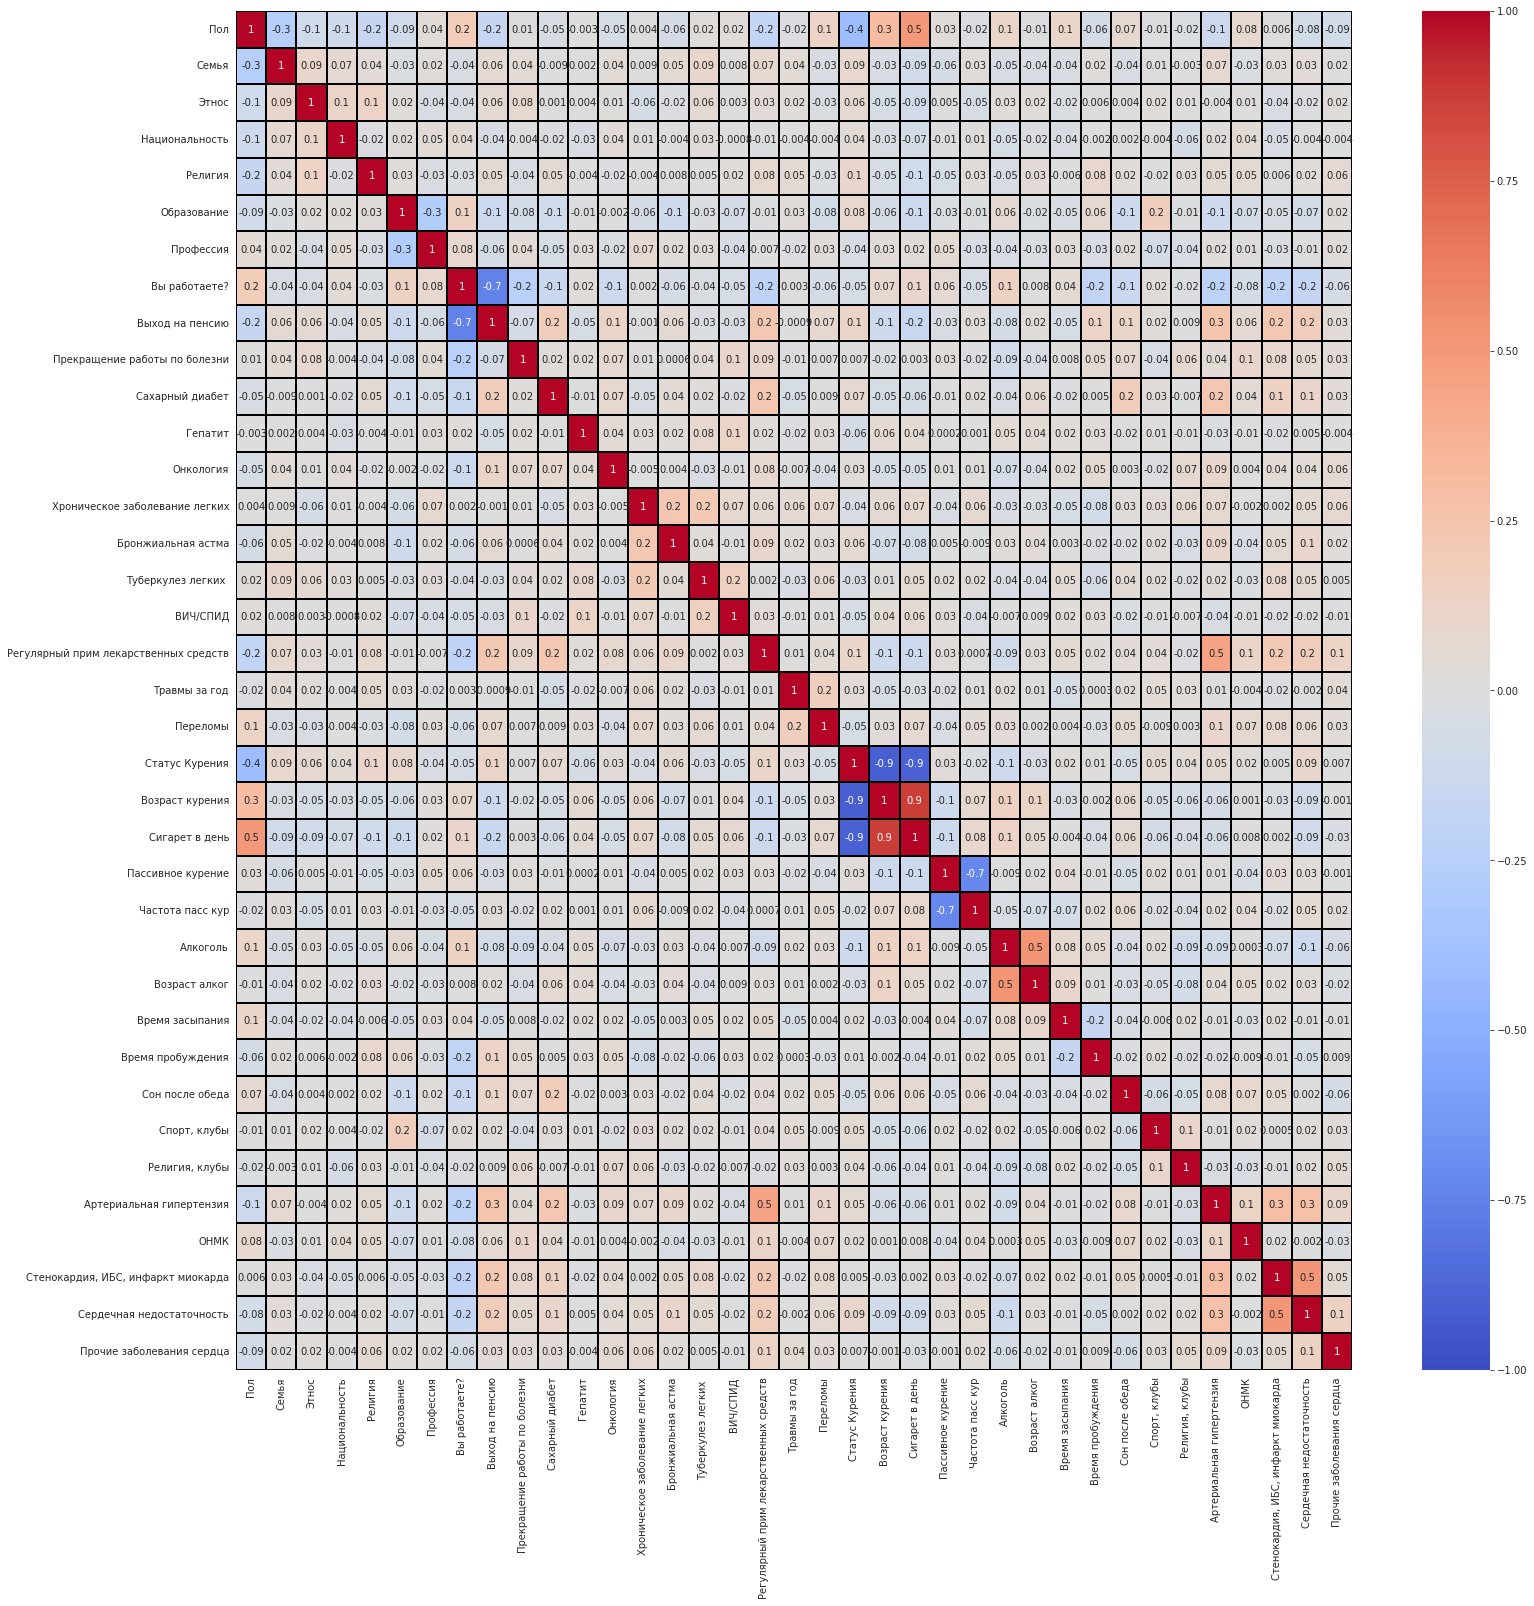

In [ ]:
# Вывод матрицы корреляции
worker.matrix_corr()

In [ ]:
# Создание выборок
worker.create_sets()

Выборки созданы! Размеры:
x_train: (859, 32)
y_train: (859, 5)
x_val: (96, 32)
y_val: (96, 5)


In [ ]:
worker.x_train

array([[2., 0., 1., ..., 1., 0., 0.],
       [1., 2., 1., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [2., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
worker.y_train

# Эксперименты

## KerasTuner

KerasTuner - это библиотека Python для автоматического поиска оптимальных гиперпараметров модели глубокого обучения. Она разработана для работы вместе с библиотекой глубокого обучения Keras и позволяет оптимизировать гиперпараметры моделей Keras в автоматическом режиме.

Основные параметры KerasTuner:

HyperParameters: класс, представляющий гиперпараметры, которые могут быть оптимизированы. Это может быть любой параметр модели, например, количество слоев, количество нейронов в каждом слое, скорость обучения, коэффициенты регуляризации и т.д.

Tuner: класс, представляющий метод оптимизации гиперпараметров. Существует несколько различных методов, которые могут быть использованы, например, случайный поиск, оптимизация Байеса и эволюционные алгоритмы.

HyperModel: класс, представляющий модель, гиперпараметры которой могут быть оптимизированы. Это может быть любая модель, определенная в Keras.

TunerCallback: класс, представляющий пользовательскую функцию обратного вызова, которая может быть вызвана на каждой итерации оптимизации гиперпараметров. Это может быть полезно, например, для вывода информации о процессе оптимизации или для отслеживания метрик.

KerasTuner предоставляет API для настройки и запуска оптимизации гиперпараметров моделей глубокого обучения. Это может быть полезно для определения оптимальных гиперпараметров при работе с новыми задачами и для автоматического улучшения производительности моделей глубокого обучения.

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00


## Эксперимент 1

tuner = RandomSearch

max_trials=20


**RandomSearch** - это алгоритм оптимизации, реализованный в библиотеке keras-tuner. Он представляет собой метод случайного поиска в пространстве гиперпараметров модели.

Алгоритм **RandomSearch** создает случайный набор гиперпараметров, используя заданные диапазоны для каждого гиперпараметра. Затем он строит и оценивает модель с этими гиперпараметрами. Этот процесс повторяется заданное количество раз (max_trials) или до тех пор, пока не будет достигнуто определенное условие остановки.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import pandas as pd

# Создание модели
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), activation='relu'))
    model.add(layers.Dense(5))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name="recall"), Precision(name="precision")])
    return model

# Создание объекта RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Heart_disease')

# Обучение модели
tuner.search(worker.x_train, worker.y_train, 
             epochs=10, validation_data=(worker.x_val, worker.y_val))


Trial 20 Complete [00h 00m 14s]
val_accuracy: 0.9791666865348816

Best val_accuracy So Far: 0.9791666865348816
Total elapsed time: 00h 04m 26s


In [ ]:
# Получение лучшей модели
best_model = tuner.get_best_models(num_models=1)[0]


In [ ]:
# Построение модели на данных для вывода ее структуры
best_model.build((None, 32))

# Вывод структуры лучшей модели
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 192)               24768     
                                                                 
 dense_2 (Dense)             (None, 224)               43232     
                                                                 
 dense_3 (Dense)             (None, 224)               50400     
                                                                 
 dense_4 (Dense)             (None, 160)               36000     
                                                                 
 dense_5 (Dense)             (None, 5)                 805       
                                                                 
Total params: 159,429
Trainable params: 159,429
Non-trai

Вызов  метода results_summary после завершения поиска позволяет получить таблицу, которая содержит для каждой пройденной модели ее гиперпараметры и метрики качества (например, accuracy, loss и т.д.). Также эта таблица сортируется по значению метрики, что позволяет быстро определить лучшую модель.

Этот метод может быть очень полезен при выборе наилучшей модели из списка моделей, предоставленных объектом tuner, так как он дает краткую и наглядную сводку всех рассмотренных моделей, и их соответствующие метрики.

In [ ]:
# сводная информация о результатах поиска модели с помощью Keras Tuner.
tuner.results_summary()

Results summary
Results in my_dir/Heart_disease
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
units_1: 192
learning_rate: 0.01
units_2: 224
units_3: 224
units_4: 160
units_5: 160
units_6: 96
Score: 0.9791666865348816
Trial summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 32
learning_rate: 0.001
units_2: 32
units_3: 192
units_4: 96
units_5: 32
units_6: 224
Score: 0.9791666865348816
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
units_1: 256
learning_rate: 0.001
units_2: 64
units_3: 96
units_4: 192
units_5: 192
units_6: 256
units_7: 32
Score: 0.9791666865348816
Trial summary
Hyperparameters:
num_layers: 6
units_0: 160
units_1: 192
learning_rate: 0.01
units_2: 32
units_3: 64
units_4: 32
units_5: 256
units_6: 32
units_7: 192
Score: 0.9791666865348816
Trial summary
Hyperparameters:
num_layers: 8
units_0: 64
units_1: 256
learning_rate: 0.0001
units_2: 64
units_3: 160
units_4: 32
units_5: 224
units_6: 192
units_7: 96
Score: 0.979166686

## Эксперимент 2

**Hyperband**: алгоритм, который выбирает модели на основе их производительности на небольших выборках данных. Он настраивает гиперпараметры более эффективно, чем случайный поиск, за счет остановки обучения худших моделей на ранних этапах.

Параметр **factor=3**. Этот параметр определяет, какой процент лучших наборов гиперпараметров передается на следующий раунд (уровень) алгоритма. После каждого уровня лучшие третьи наборы гиперпараметров будут использоваться в следующем уровне, а остальные отбрасываются. Таким образом, этот параметр влияет на то, как быстро алгоритм Hyperband сходится к оптимальным гиперпараметрам.

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(5, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name="recall"), Precision(name="precision")])

    return model

In [ ]:
from kerastuner.tuners import Hyperband
tuner = Hyperband(build_model, objective='val_accuracy', 
                  max_epochs=10, factor=3, directory='my_dir', project_name='Heart_disease2')

In [ ]:
# Обучение модели
tuner.search(worker.x_train, worker.y_train, 
             epochs=10, validation_data=(worker.x_val, worker.y_val))

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.9791666865348816

Best val_accuracy So Far: 0.9791666865348816
Total elapsed time: 00h 01m 15s


In [ ]:
# Получение лучшей модели
best_model2 = tuner.get_best_models(num_models=1)[0]
# Построение модели на данных для вывода ее структуры
best_model2.build((None, 32))

# Вывод структуры лучшей модели
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               7392      
                                                                 
 activation (Activation)     (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 224)               50400     
                                                                 
 activation_1 (Activation)   (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1125      
                                                                 
Total params: 58,917
Trainable params: 58,917
Non-trainable params: 0
_________________________________________________________________


## Эксперимент 3

tuner = BayesianOptimization

Метод **Байесовской оптимизации** используется для оптимизации функций, которые не являются гладкими или дифференцируемыми. Он представляет функцию целевой метрики как вероятностную модель, а затем использует байесовское обновление для поиска оптимальных значений гиперпараметров. Таким образом, метод Байесовской оптимизации позволяет ускорить процесс настройки гиперпараметров в сравнении с классическим перебором гиперпараметров.

In [ ]:
from kerastuner import BayesianOptimization
from tensorflow.keras.layers import BatchNormalization

def build_model(hp):
    model = keras.Sequential()
    model.add(BatchNormalization())
    model.add(layers.Dense(units=hp.Int('units', 32, 512, 32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(layers.Dense(5, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', Recall(name="recall"), Precision(name="precision")])
    return model
  
# Создание объекта BayesianOptimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Heart_disease3')

# Обучение модели
tuner.search(worker.x_train, worker.y_train, 
             epochs=10, validation_data=(worker.x_val, worker.y_val))


Trial 20 Complete [00h 00m 10s]
val_accuracy: 0.2743055572112401

Best val_accuracy So Far: 0.9826388955116272
Total elapsed time: 00h 04m 06s


In [ ]:
# Получение лучшей модели и ее гиперпараметров
best_model3 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Чтобы увидеть наилучшие значения гиперпараметров, найденные в процессе поиска, можно вывести содержимое объекта best_hyperparameters
best_hyperparams_values = best_hyperparameters.get_config()
print('Наилучшие значения гиперпараметров:')
for key, value in best_hyperparams_values.items():
    print(f'{key}: {value}')

Наилучшие значения гиперпараметров:
space: [{'class_name': 'Int', 'config': {'name': 'units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}]
values: {'units': 512, 'dropout': 0.0, 'learning_rate': 0.001}


In [ ]:
# Построение модели на данных для вывода ее структуры
best_model3.build((None, 32))

# Вывод структуры лучшей модели
best_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 21,637
Trainable params: 20,549
Non-traina

# Датасет с изображениями

## Загрузка датасета и подготовка выборок

In [ ]:
#@title Загрузка датасета и подготовка выборок
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

In [ ]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=24,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=24,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (341, 64, 128, 3), (341, 3), батчей: 1

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


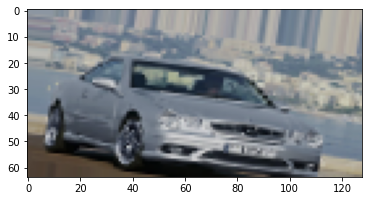

In [ ]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

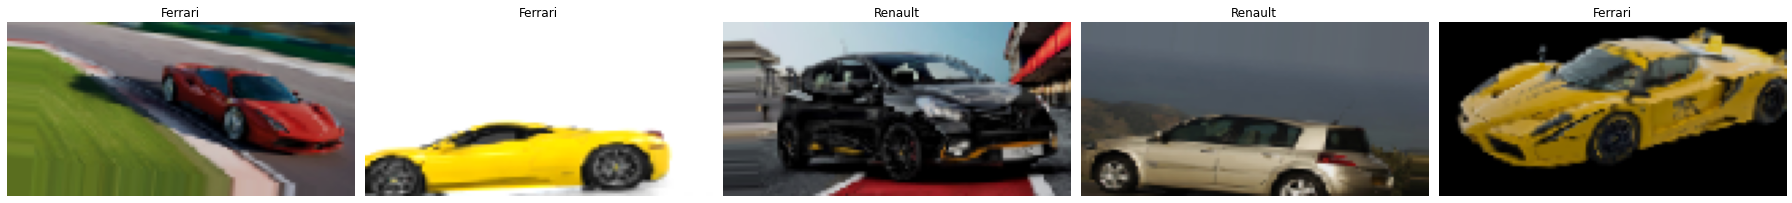

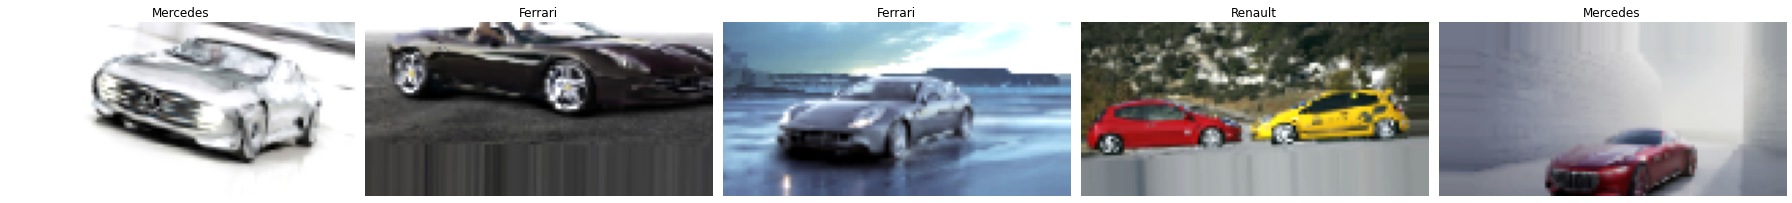

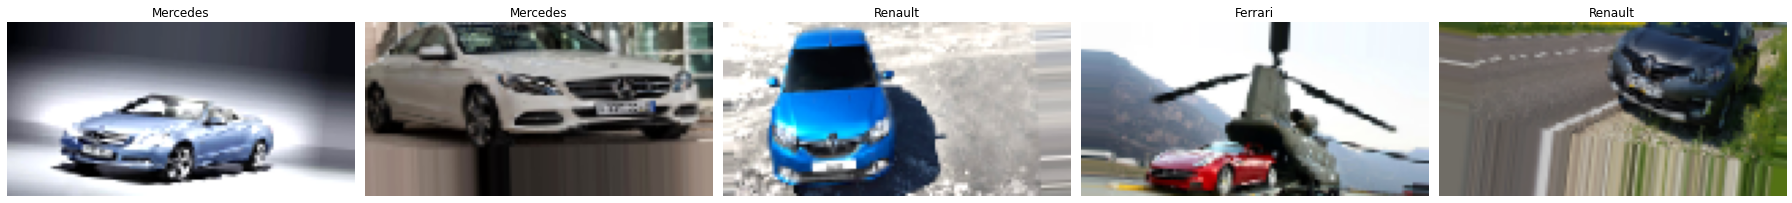

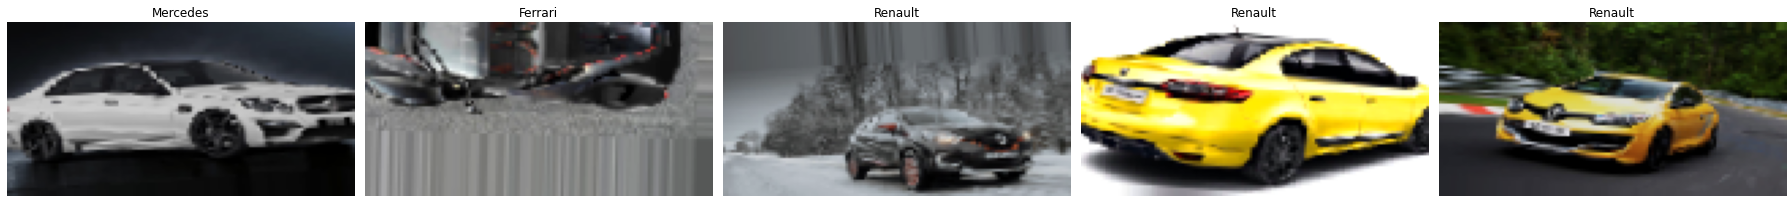

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

In [ ]:
# Получение всех данных из генератора
data = []
labels = []
for batch in train_generator:
    data.append(batch[0])
    labels.append(batch[1])
    if len(data) * 32 >= len(train_generator.filenames):
        break

# Преобразование данных и меток в numpy массивы
x = np.concatenate(data)
y = np.concatenate(labels)

In [ ]:
# Получение всех данных из генератора
data = []
labels = []
for batch in validation_generator:
    data.append(batch[0])
    labels.append(batch[1])
    if len(data) * 32 >= len(validation_generator.filenames):
        break

# Преобразование данных и меток в numpy массивы
x_val = np.concatenate(data)
y_val = np.concatenate(labels)

In [ ]:
# Получение всех данных из генератора
data = []
labels = []
for batch in test_generator:
    data.append(batch[0])
    labels.append(batch[1])
    if len(data) * 32 >= len(test_generator.filenames):
        break

# Преобразование данных и меток в numpy массивы
x_test = np.concatenate(data)
y_test = np.concatenate(labels)

## Эксперимент 1

max_trials=10

tuner = RandomSearch

In [ ]:
# Определение функции для построения модели
def model_builder(hp):
  model = Sequential()
  #Настраиваем параметры  у первого слоя Conv2D
  hp_units_conv2D = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Conv2D(filters=hp_units_conv2D, kernel_size=3, activation='relu'))
  model.add(Flatten())
  model.add(Dense(3))

  # Настраиваем параметр learning rate для оптимайзера
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

# Определение гиперпараметров для настройки
tuner_search = RandomSearch(model_builder,
                            objective='val_accuracy',
                            max_trials=10,
                            directory='output',
                            project_name='cars_keras_tuner')

# Запуск настройки гиперпараметров
tuner_search.search(x, y, epochs=10, batch_size=64,  validation_data=(x_val, y_val))

# Получение наилучшей модели
best_model = tuner_search.get_best_models(num_models=1)[0]

# Оценка наилучшей модели на тестовых данных
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

Trial 10 Complete [00h 11m 23s]
val_accuracy: 0.3583333194255829

Best val_accuracy So Far: 0.4104166626930237
Total elapsed time: 01h 34m 29s


118/118 [==============================] - 7s 54ms/step - loss: 5.5303 - accuracy: 0.4018
Test accuracy: 0.401759535074234


In [ ]:
# Построение модели на данных для вывода ее структуры
best_model.build((None, 64, 128, 3))

# Вывод структуры лучшей модели
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       896       
                                                                 
 flatten (Flatten)           (None, 249984)            0         
                                                                 
 dense (Dense)               (None, 3)                 749955    
                                                                 
Total params: 750,851
Trainable params: 750,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_hyperparameters = tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Чтобы увидеть наилучшие значения гиперпараметров, найденные в процессе поиска, можно вывести содержимое объекта best_hyperparameters
best_hyperparams_values = best_hyperparameters.get_config()
print('Наилучшие значения гиперпараметров:')
for key, value in best_hyperparams_values.items():
    print(f'{key}: {value}')

Наилучшие значения гиперпараметров:
space: [{'class_name': 'Int', 'config': {'name': 'units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}]
values: {'units': 32, 'learning_rate': 0.001}


## Эксперимент 2

tuner = Hyperband



**Hyperband** - это один из возможных алгоритмов настройки гиперпараметров в Keras Tuner. Он использует технику "ассоциативного поиска" (successive halving), которая позволяет быстро отбрасывать неэффективные наборы гиперпараметров и сконцентрироваться на более перспективных.

**hyperband_iterations** - это гиперпараметр, который используется в библиотеке Keras Tuner для определения того, как много раз будет запущен алгоритм Hyperband для поиска наилучших гиперпараметров модели.

**max_epochs** - это гиперпараметр, который указывает максимальное число эпох, которые могут быть выполнены при обучении каждой модели в процессе настройки гиперпараметров с помощью алгоритма Hyperband в библиотеке Keras Tuner.

Алгоритм Hyperband состоит из серии итераций, в каждой итерации происходит запуск нескольких моделей с различными наборами гиперпараметров на некоторое число эпох, после чего наилучшие модели продолжают обучение в следующей итерации. Параметр max_epochs задает максимальное число эпох, которые каждая из этих моделей может использовать для обучения в каждой итерации.

In [ ]:
from kerastuner.tuners import Hyperband 
from tensorflow import keras
from tensorflow.keras import layers
# Определение функции создания модели с помощью Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # Выбор гиперпараметров для каждого слоя
    # Определение оптимальных параметров для conv2D слоев
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(64, 128, 3)
    ))

    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))

    # Определение оптимальных параметров для maxpool слоев
    model.add(layers.MaxPooling2D(
        pool_size=hp.Choice('pool_1_pool_size', values=[2, 3]),
    ))

    model.add(layers.Flatten())
    
    # Определение оптимальных параметров для dense слоев
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))

    # Определение оптимальных параметров для выходного слоя
    model.add(layers.Dense(3, activation='softmax'))

    # Определение оптимальных параметров для оптимизатора
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Использование Keras Tuner для поиска наилучшей модели
tuner2 = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='cars2'
)

# Запуск поиска наилучшей модели
tuner2.search(x, y, epochs=10, validation_data=(x_val, y_val))


Trial 60 Complete [00h 00m 22s]
val_accuracy: 0.3687500059604645

Best val_accuracy So Far: 0.5583333373069763
Total elapsed time: 00h 11m 49s


In [ ]:
# Получение наилучшей модели и ее обучение на полной выборке
best_model2 = tuner2.get_best_models()[0]
best_model2.build(input_shape=(None, 64, 128, 3))

In [ ]:
# Вывод структуры лучшей модели
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 80)       2240      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 124, 64)       46144     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 41, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 52480)             0         
                                                                 
 dense (Dense)               (None, 48)                2519088   
                                                                 
 dense_1 (Dense)             (None, 3)                 147       
                                                        

## Эксперимент 3

Tuner BayesianOptimization

max_trials=30

**num_initial_points** - это количество начальных случайных значений гиперпараметров, которые будут использоваться перед началом оптимизации. Например, если мы установим num_initial_points=2, тюнер сначала случайным образом выберет 2 набора значений гиперпараметров, а затем начнет оптимизацию с использованием этих значений в качестве начальных точек. 

In [ ]:
import tensorflow as tf
from kerastuner import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

# Определение функции для построения модели с заданными гиперпараметрами
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Добавление сверточных слоев
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(64, 128, 3)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Int('pool_size', min_value=2, max_value=4)))
    
    # Добавление нескольких сверточных слоев
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=32, max_value=512, step=32),
            kernel_size=hp.Int('kernel_size_' + str(i), min_value=3, max_value=5, step=1),
            activation='relu', padding="same"
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Int('pool_size_' + str(i), min_value=2, max_value=4)))
    
    # Добавление полносвязных слоев
    model.add(tf.keras.layers.Flatten())
    for j in range(hp.Int('dense_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(j), min_value=32, max_value=1024, step=32),
            activation='relu'
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(j), 0, 0.5, step=0.1)))
    
    # Выходной слой с функцией активации softmax
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    # Определение оптимизатора и метрики для модели
    optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



<ipython-input-17-9eecb800755b>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import BayesianOptimization


In [ ]:
# Создание экземпляра тюнера BayesianOptimization
tuner3 = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    num_initial_points=5)
# Запуск поиска оптимальных гиперпараметров
tuner3.search(
    x,
    y,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=24,
    verbose=1
)

Trial 30 Complete [00h 02m 37s]
val_accuracy: 0.6395833492279053

Best val_accuracy So Far: 0.6479166746139526
Total elapsed time: 01h 43m 03s


In [ ]:
# Получение наилучшей модели и ее обучение на полной выборке
best_model3 = tuner3.get_best_models()[0]
best_model3.build(input_shape=(None, 64, 128, 3))

In [ ]:
# Вывод структуры лучшей модели
best_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 62, 126, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 63, 480)       384480    
                                                                 
 batch_normalization_1 (Batc  (None, 31, 63, 480)      1920      
 hNormalization)                                                 
                                                        

# Эксперименты без использования KerasTuner

### Табличные данные

#### **Эксп. №1 (0.61)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(16, input_dim=32, activation='relu'))
  model.add(Dense(5, activation='sigmoid'))

  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 12ms/step - loss: 1.6728 - accuracy: 0.5402 - recall: 0.7151 - precision: 0.2001 - val_loss: 0.9694 - val_accuracy: 0.5938 - val_recall: 0.6234 - val_precision: 0.2096
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.7847 - accuracy: 0.7008 - recall: 0.5416 - precision: 0.2706 - val_loss: 0.5197 - val_accuracy: 0.7292 - val_recall: 0.4416 - val_precision: 0.3953
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 0.5662 - accuracy: 0.6764 - recall: 0.3639 - precision: 0.3505 - val_loss: 0.4545 - val_accuracy: 0.7917 - val_recall: 0.3506 - val_precision: 0.4426
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.5008 - accuracy: 0.7544 - recall: 0.3131 - precision: 0.3598 - val_loss: 0.4273 - val_accuracy: 0.8438 - val_recall: 0.3247 - val_precision: 0.4630
Epoch 5/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4654 - accuracy: 0.7928 - recall: 0.3

График обучения:


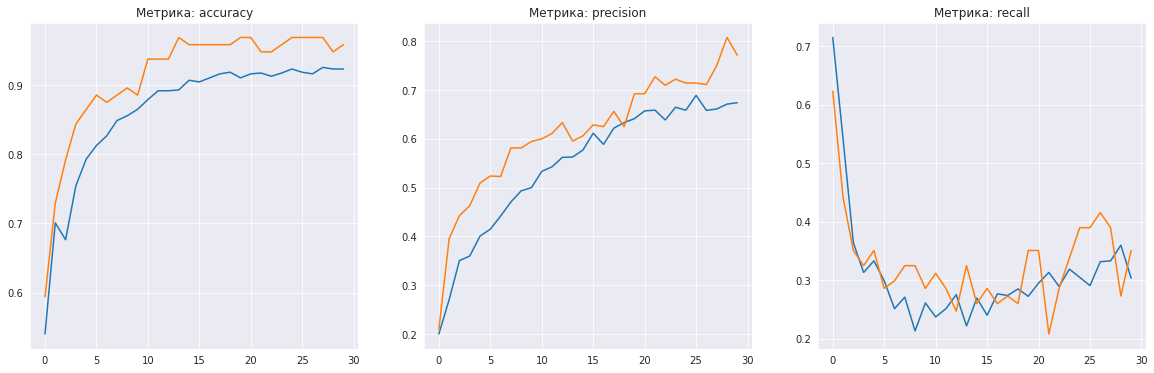

Максимальная точность на обучающей выборке: 0.925
Максимальная точность на проверочной выборке: 0.969
Максимальная метрика precision  на обучающей выборке: 0.689
Максимальная метрика precision  на проверочной выборке: 0.808
Максимальная метрика recall на обучающей выборке: 0.715
Максимальная метрика recall на проверочной выборке: 0.623


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.467
Максимальная метрика precision на проверочной выборке: 0.0

Максимальная метрика recall на обучающей выборке: 0.387
Максимальная метрика recall на проверочной выборке: 0.0




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.767
Максимальная метрика precision на проверочной выборке: 0.0

Максимальная метрика recall на обучающей выборке: 0.38
Максимальная метрика recall на проверочной выборке: 0.0




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.466
Максимальная метрика precision на проверочной выборке: 0.0

М

#### **Эксп. №2 (добавление BatchNormalization+Dropout) (0.61)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(16, input_dim=32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(5, activation='sigmoid'))

  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)
  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 23ms/step - loss: 0.7854 - accuracy: 0.2584 - recall: 0.4288 - precision: 0.1719 - val_loss: 1.4707 - val_accuracy: 0.0521 - val_recall: 0.6623 - val_precision: 0.1266
Epoch 2/30
35/35 [==============================] - 0s 5ms/step - loss: 0.7314 - accuracy: 0.2806 - recall: 0.4528 - precision: 0.1828 - val_loss: 0.9397 - val_accuracy: 0.1146 - val_recall: 0.5974 - val_precision: 0.1353
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.2794 - recall: 0.3865 - precision: 0.1849 - val_loss: 0.7225 - val_accuracy: 0.1875 - val_recall: 0.4935 - val_precision: 0.1704
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.3038 - recall: 0.3709 - precision: 0.2206 - val_loss: 0.6273 - val_accuracy: 0.2396 - val_recall: 0.3896 - val_precision: 0.1935
Epoch 5/30
35/35 [==============================] - 0s 5ms/step - loss: 0.5901 - accuracy: 0.3644 - recall: 0.3

График обучения:


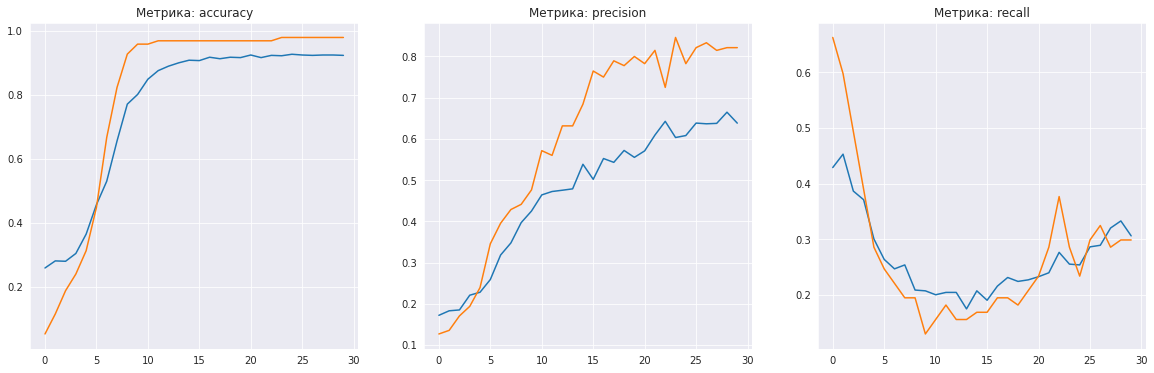

Максимальная точность на обучающей выборке: 0.927
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.665
Максимальная метрика precision  на проверочной выборке: 0.846
Максимальная метрика recall на обучающей выборке: 0.453
Максимальная метрика recall на проверочной выборке: 0.662


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.476
Максимальная метрика precision на проверочной выборке: 0.49

Максимальная метрика recall на обучающей выборке: 0.522
Максимальная метрика recall на проверочной выборке: 0.61




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.473
Максимальная метрика precision на проверочной выборке: 0.49

Максимальная метрика recall на обучающей выборке: 0.345
Максимальная метрика recall на проверочной выборке: 0.61




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.656
Максимальная метрика precision на проверочной выборке: 0

#### **Эксп. №3 (добавление Dense) (0.623)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(16, input_dim=32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 13ms/step - loss: 0.6590 - accuracy: 0.1944 - recall: 0.3053 - precision: 0.1934 - val_loss: 0.6190 - val_accuracy: 0.0208 - val_recall: 0.0130 - val_precision: 0.0303
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.5162 - accuracy: 0.5285 - recall: 0.1975 - precision: 0.2911 - val_loss: 0.4490 - val_accuracy: 0.5521 - val_recall: 0.0130 - val_precision: 0.2500
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4418 - accuracy: 0.7893 - recall: 0.1749 - precision: 0.3987 - val_loss: 0.4056 - val_accuracy: 0.9792 - val_recall: 0.1039 - val_precision: 0.7273
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4073 - accuracy: 0.8847 - recall: 0.1721 - precision: 0.4729 - val_loss: 0.3892 - val_accuracy: 0.9792 - val_recall: 0.1818 - val_precision: 0.7368
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.9104 - recall: 0.1

График обучения:


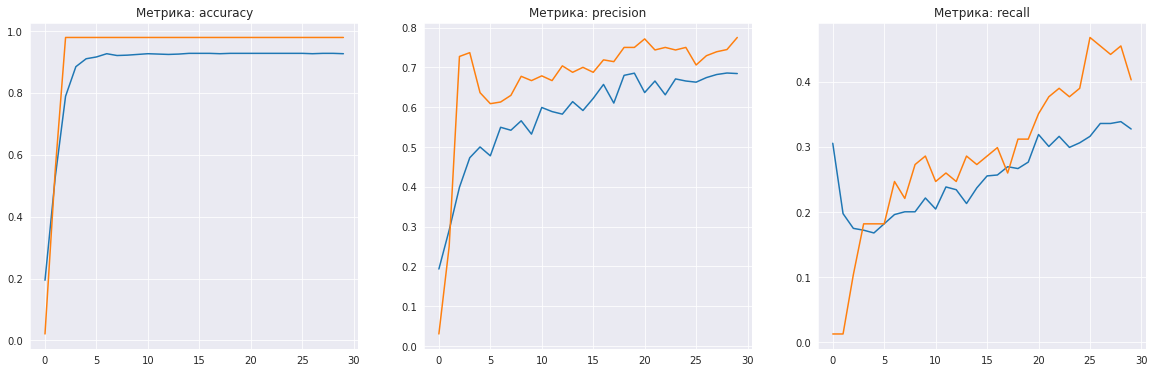

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.686
Максимальная метрика precision  на проверочной выборке: 0.775
Максимальная метрика recall на обучающей выборке: 0.339
Максимальная метрика recall на проверочной выборке: 0.468


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.703
Максимальная метрика precision на проверочной выборке: 0.85

Максимальная метрика recall на обучающей выборке: 0.444
Максимальная метрика recall на проверочной выборке: 0.61




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.725
Максимальная метрика precision на проверочной выборке: 0.789

Максимальная метрика recall на обучающей выборке: 0.408
Максимальная метрика recall на проверочной выборке: 0.506




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.706
Максимальная метрика precision на проверочной выборке:

#### **Эксп. №4 (Увеличение нейронов в первом Dense) (0.636)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 14ms/step - loss: 0.6737 - accuracy: 0.1676 - recall: 0.2583 - precision: 0.1545 - val_loss: 0.5208 - val_accuracy: 0.4375 - val_recall: 0.2727 - val_precision: 0.2530
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy: 0.6298 - recall: 0.1890 - precision: 0.3976 - val_loss: 0.3959 - val_accuracy: 0.9167 - val_recall: 0.2987 - val_precision: 0.6053
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.8382 - recall: 0.2299 - precision: 0.5525 - val_loss: 0.3730 - val_accuracy: 0.9792 - val_recall: 0.3506 - val_precision: 0.6923
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.3812 - accuracy: 0.8789 - recall: 0.2468 - precision: 0.5932 - val_loss: 0.3645 - val_accuracy: 0.9792 - val_recall: 0.3506 - val_precision: 0.6750
Epoch 5/30
35/35 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.8836 - recall: 0.2

График обучения:


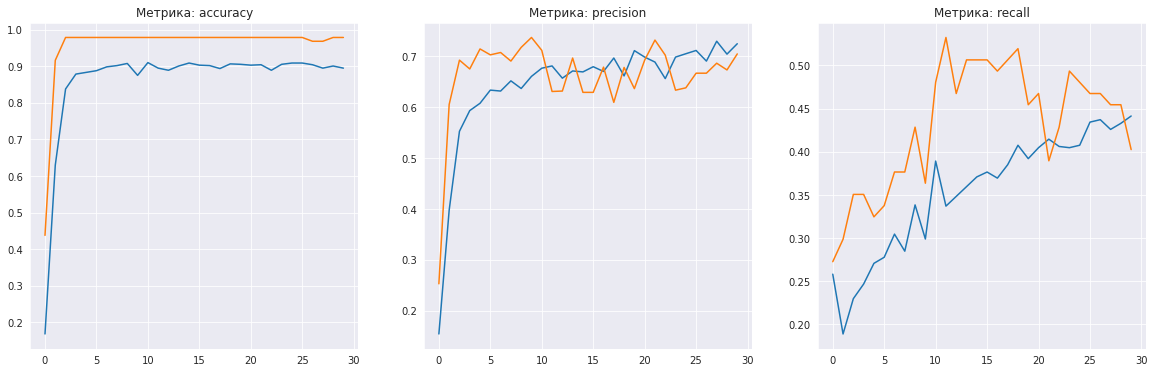

Максимальная точность на обучающей выборке: 0.91
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.729
Максимальная метрика precision  на проверочной выборке: 0.737
Максимальная метрика recall на обучающей выборке: 0.441
Максимальная метрика recall на проверочной выборке: 0.532


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.919
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.763
Максимальная метрика precision на проверочной выборке: 0.781

Максимальная метрика recall на обучающей выборке: 0.496
Максимальная метрика recall на проверочной выборке: 0.468




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.922
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.759
Максимальная метрика precision на проверочной выборке: 0.88

Максимальная метрика recall на обучающей выборке: 0.526
Максимальная метрика recall на проверочной выборке: 0.532




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.922
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.74
Максимальная метрика precision на проверочной выборке:

#### **Эксп. №5 (Добавление Dense) (0.753)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 13ms/step - loss: 0.7181 - accuracy: 0.2119 - recall: 0.4440 - precision: 0.1788 - val_loss: 0.6689 - val_accuracy: 0.5417 - val_recall: 0.6234 - val_precision: 0.2182
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.3620 - recall: 0.4443 - precision: 0.2191 - val_loss: 0.6069 - val_accuracy: 0.4688 - val_recall: 0.5844 - val_precision: 0.2632
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 0.5268 - accuracy: 0.5076 - recall: 0.4090 - precision: 0.3142 - val_loss: 0.4877 - val_accuracy: 0.5104 - val_recall: 0.4156 - val_precision: 0.3404
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.6438 - recall: 0.3032 - precision: 0.3853 - val_loss: 0.4159 - val_accuracy: 0.8542 - val_recall: 0.2987 - val_precision: 0.5750
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 0.3989 - accuracy: 0.8033 - recall: 0.2

График обучения:


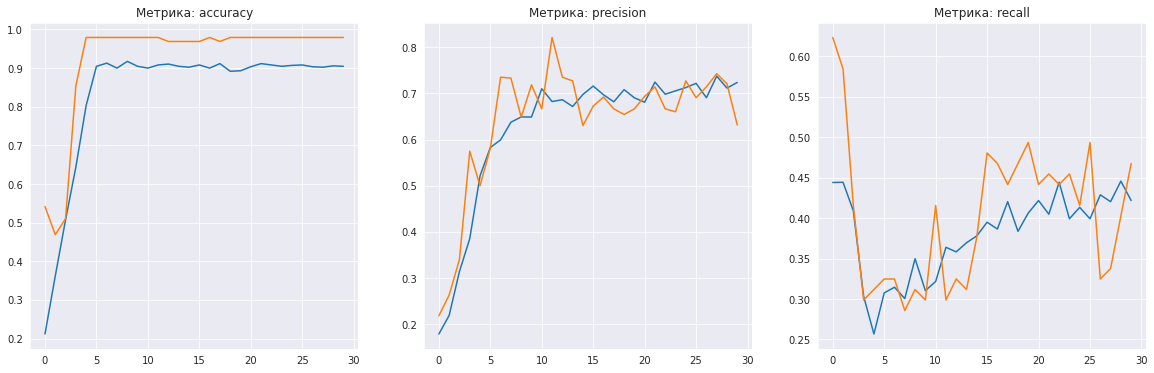

Максимальная точность на обучающей выборке: 0.917
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.738
Максимальная метрика precision  на проверочной выборке: 0.821
Максимальная метрика recall на обучающей выборке: 0.446
Максимальная метрика recall на проверочной выборке: 0.623


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.925
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.758
Максимальная метрика precision на проверочной выборке: 0.788

Максимальная метрика recall на обучающей выборке: 0.491
Максимальная метрика recall на проверочной выборке: 0.494




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.747
Максимальная метрика precision на проверочной выборке: 0.812

Максимальная метрика recall на обучающей выборке: 0.489
Максимальная метрика recall на проверочной выборке: 0.481




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.927
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.777
Максимальная метрика precision на проверочной выборк

#### **Эксп. №6 (Замена relu на sigmoid) (0.792)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 13ms/step - loss: 0.6033 - accuracy: 0.0664 - recall: 0.1438 - precision: 0.1462 - val_loss: 0.5415 - val_accuracy: 0.9062 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 0.5191 - accuracy: 0.7357 - recall: 0.0409 - precision: 0.4143 - val_loss: 0.4697 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.9208 - recall: 0.0719 - precision: 0.6071 - val_loss: 0.4227 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4240 - accuracy: 0.9278 - recall: 0.0691 - precision: 0.6712 - val_loss: 0.3965 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4031 

График обучения:


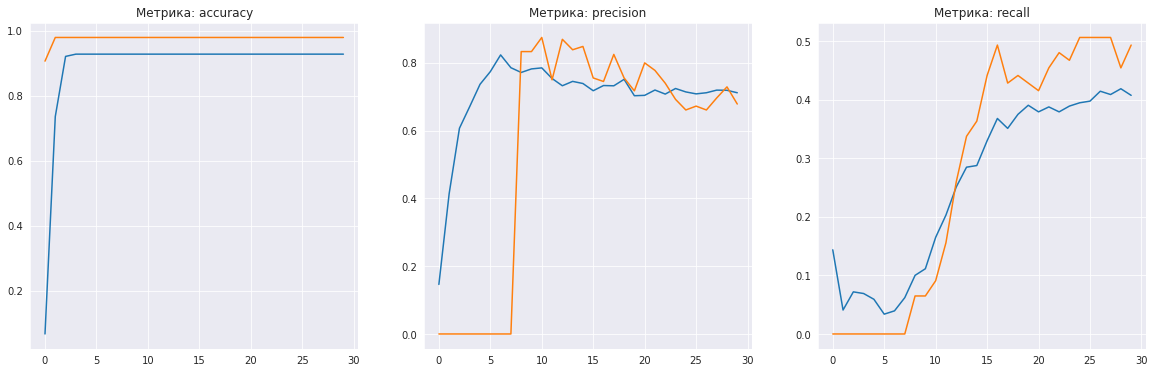

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.824
Максимальная метрика precision  на проверочной выборке: 0.875
Максимальная метрика recall на обучающей выборке: 0.419
Максимальная метрика recall на проверочной выборке: 0.506


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.692
Максимальная метрика precision на проверочной выборке: 0.889

Максимальная метрика recall на обучающей выборке: 0.477
Максимальная метрика recall на проверочной выборке: 0.74




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.692
Максимальная метрика precision на проверочной выборке: 0.821

Максимальная метрика recall на обучающей выборке: 0.5
Максимальная метрика recall на проверочной выборке: 0.506




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.925
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.696
Максимальная метрика precision на проверочной выборке: 

#### **Эксп. №7 (Замена binary_crossentropy на categorical_crossentropy) (0.805)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 14ms/step - loss: 1.5458 - accuracy: 0.0116 - recall: 0.0954 - precision: 0.1761 - val_loss: 1.3964 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 1.3557 - accuracy: 0.0431 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.2392 - val_accuracy: 0.4583 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 1.2290 - accuracy: 0.7264 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.1300 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 1.1489 - accuracy: 0.9255 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0567 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/30
35/35 [==============================] -

График обучения:


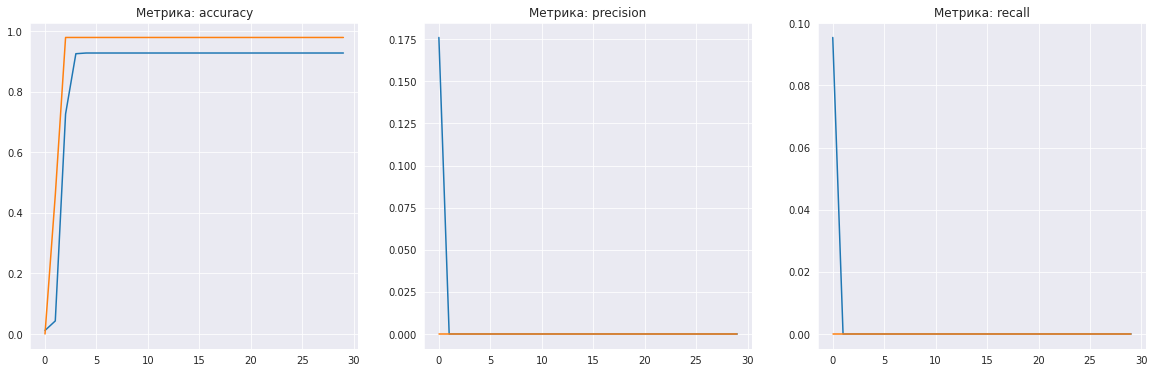

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.176
Максимальная метрика precision  на проверочной выборке: 0.0
Максимальная метрика recall на обучающей выборке: 0.095
Максимальная метрика recall на проверочной выборке: 0.0


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.923
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.714
Максимальная метрика precision на проверочной выборке: 0.829

Максимальная метрика recall на обучающей выборке: 0.389
Максимальная метрика recall на проверочной выборке: 0.455




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.921
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.713
Максимальная метрика precision на проверочной выборке: 0.794

Максимальная метрика recall на обучающей выборке: 0.382
Максимальная метрика recall на проверочной выборке: 0.494




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.729
Максимальная метрика precision на проверочной выборк

#### **Эксп. №8 (Увеличение шага обучения до 0.014) (0.818)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.014), loss='categorical_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=30, 
                           verbose=1)

Epoch 1/30
35/35 [==============================] - 2s 14ms/step - loss: 1.3403 - accuracy: 0.3097 - recall: 0.3117 - precision: 0.1920 - val_loss: 1.0996 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 2/30
35/35 [==============================] - 0s 4ms/step - loss: 1.1232 - accuracy: 0.9278 - recall: 0.5628 - precision: 0.4524 - val_loss: 0.9976 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 1.0735 - accuracy: 0.9278 - recall: 0.5628 - precision: 0.4645 - val_loss: 0.9759 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 4/30
35/35 [==============================] - 0s 4ms/step - loss: 1.0612 - accuracy: 0.9278 - recall: 0.5628 - precision: 0.4645 - val_loss: 0.9705 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 1.0560 - accuracy: 0.9278 - recall: 0.5

График обучения:


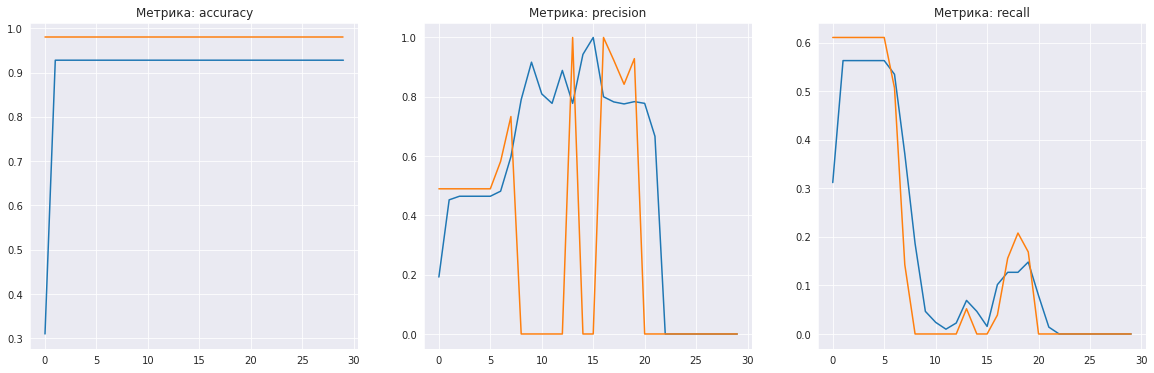

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 1.0
Максимальная метрика precision  на проверочной выборке: 1.0
Максимальная метрика recall на обучающей выборке: 0.563
Максимальная метрика recall на проверочной выборке: 0.61


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 1.0
Максимальная метрика precision на проверочной выборке: 0.875

Максимальная метрика recall на обучающей выборке: 0.44
Максимальная метрика recall на проверочной выборке: 0.545




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.773
Максимальная метрика precision на проверочной выборке: 1.0

Максимальная метрика recall на обучающей выборке: 0.444
Максимальная метрика recall на проверочной выборке: 0.532




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 1.0
Максимальная метрика precision на проверочной выборке: 1.0


#### **Эксп. №9 (Добавление еще одного полносвязного слоя) (0.857)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(128, input_dim=32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(8, activation='sigmoid'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.014), loss='categorical_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=100, 
                           verbose=1)

Epoch 1/100
35/35 [==============================] - 2s 14ms/step - loss: 1.1443 - accuracy: 0.7579 - recall: 0.6514 - precision: 0.2575 - val_loss: 0.9554 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 1.0515 - accuracy: 0.9278 - recall: 0.5628 - precision: 0.4645 - val_loss: 0.9697 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0567 - accuracy: 0.9278 - recall: 0.2003 - precision: 0.6228 - val_loss: 0.9519 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0484 - accuracy: 0.9278 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.9889 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 1.0598 - a

График обучения:


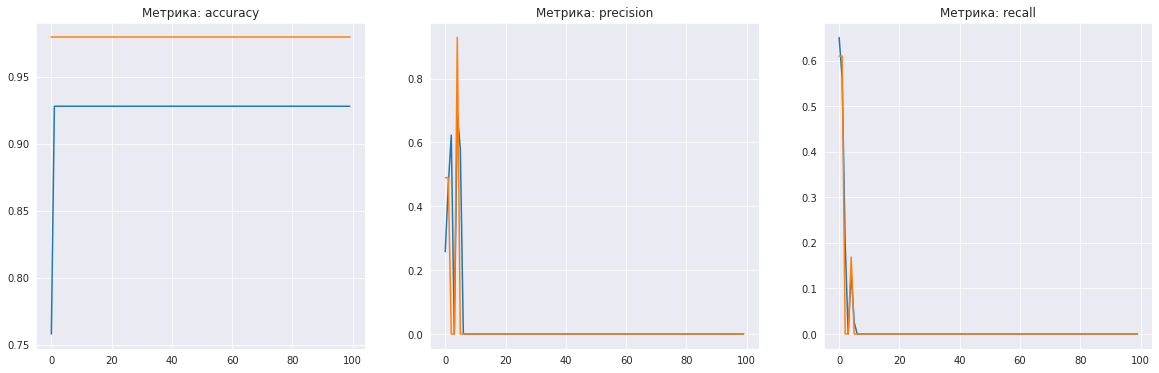

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.691
Максимальная метрика precision  на проверочной выборке: 0.929
Максимальная метрика recall на обучающей выборке: 0.651
Максимальная метрика recall на проверочной выборке: 0.61


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.789
Максимальная метрика precision на проверочной выборке: 1.0

Максимальная метрика recall на обучающей выборке: 0.628
Максимальная метрика recall на проверочной выборке: 0.675




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.738
Максимальная метрика precision на проверочной выборке: 0.875

Максимальная метрика recall на обучающей выборке: 0.568
Максимальная метрика recall на проверочной выборке: 0.662




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.759
Максимальная метрика precision на проверочной выборке:

#### **Эксп. №10 (Усиление первого полносвязного слоя) (0.883)**

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(512, input_dim=32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(.2))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(8, activation='sigmoid'))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(0.014), loss='categorical_crossentropy', metrics=metrics)

  # Компиляция модели
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(worker.x_train,
                           worker.y_train,
                           validation_data=(worker.x_val, worker.y_val),
                           shuffle=True,
                           batch_size=25,
                           epochs=100, 
                           verbose=1)

Epoch 1/100
35/35 [==============================] - 2s 15ms/step - loss: 1.1266 - accuracy: 0.8440 - recall: 0.5674 - precision: 0.3193 - val_loss: 0.9632 - val_accuracy: 0.9792 - val_recall: 0.6104 - val_precision: 0.4896
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0514 - accuracy: 0.9278 - recall: 0.3625 - precision: 0.4525 - val_loss: 0.9541 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0546 - accuracy: 0.9278 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.9532 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 1.0582 - accuracy: 0.9278 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.9618 - val_accuracy: 0.9792 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - 

График обучения:


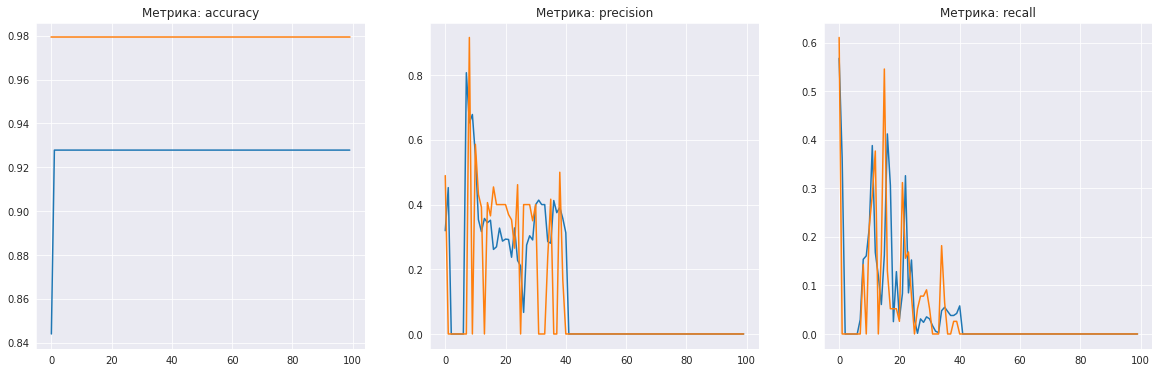

Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979
Максимальная метрика precision  на обучающей выборке: 0.808
Максимальная метрика precision  на проверочной выборке: 0.917
Максимальная метрика recall на обучающей выборке: 0.567
Максимальная метрика recall на проверочной выборке: 0.61


In [ ]:
worker.show_learning_information(store_learning)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=10)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.642
Максимальная метрика precision на проверочной выборке: 0.78

Максимальная метрика recall на обучающей выборке: 0.718
Максимальная метрика recall на проверочной выборке: 0.701




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.421
Максимальная метрика precision на проверочной выборке: 0.471

Максимальная метрика recall на обучающей выборке: 0.898
Максимальная метрика recall на проверочной выборке: 0.883




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.928
Максимальная точность на проверочной выборке: 0.979

Максимальная метрика precision на обучающей выборке: 0.697
Максимальная метрика precision на проверочной выборке

### Изображения

 https://colab.research.google.com/drive/1wR8vbQ1LSJy1ZER3wIgXENUT0K-Q15Qh?usp=sharing

 https://colab.research.google.com/drive/1f95JuEQcz2LYrCbWS3GnvnXUSN2GL2HR?usp=sharing